In [1]:
"""
We use the limit cycle to predict the motion of the slider given velocity of the pusher.
This is implementing a recent paper by Alberto

Object models to be considered:
1) cylinders
2) blocks
"""
import numpy as np
class Geometry:
    def __init__(self, shape, mins, maxs, resols):
        self.shape = shape
        self.grid_size = (maxs-mins)/resols
        self.grid_size = np.ceil(self.grid_size).astype(int)
        self.mins = mins
        self.maxs = maxs
        self.resols = resols
        self.grid = np.zeros(self.grid_size).astype(int)  # an occupancy grid
        self.grid_x, self.grid_y = np.indices(self.grid_size)
        self.grid_x = self.resols[0] * (self.grid_x+0.5) + self.mins[0]
        self.grid_y = self.resols[1] * (self.grid_y+0.5) + self.mins[1]

    def update_grid(self):
        # obtain the occupancy grid based on the shape
        pass
    def local_inside(self, pt):
        pass

class CylinderShape(Geometry):
    def __init__(self, shape, mins, maxs, resols):
        super().__init__(shape, mins, maxs, resols)
        self.update_grid()
    def update_grid(self):
        # check the points if they're inside the grid
        inside = np.sqrt(self.grid_x ** 2 + self.grid_y ** 2)
        inside = inside <= self.shape
        self.grid = inside
        print('after update_grid')
    def local_inside(self, pt):
        return np.sqrt(pt[0]**2 + pt[1]**2) <= self.shape
class BlockShape(Geometry):
    def __init__(self, shape, mins, maxs, resols):
        super().__init__(shape, mins, maxs, resols)
        self.update_grid()
    def update_grid(self):
        # check the points if they're inside the grid
        inside = (self.grid_x <= self.shape[0]/2) & (self.grid_y <= self.shape[1]/2) & \
                (self.grid_x >= -self.shape[0]/2) & (self.grid_y >= -self.shape[1]/2)
        self.grid = inside
    def local_inside(self, pt):
        inside = (pt[0] <= self.shape[0]/2) & (pt[1] <= self.shape[1]/2) & \
                (pt[0] >= -self.shape[0]/2) & (pt[1] >= -self.shape[1]/2)
        return inside
        

In [2]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

class Slider:
    def __init__(self, transform, shape):
        # transform: x,y,theta
        # shape: cylinder is radius, block is (height, width)
        self.transform = transform
        x,y,theta = transform
        tf_mat = [[np.cos(theta), -np.sin(theta),x], [np.sin(theta), np.cos(theta),y],[0,0,1]]
        tf_mat = np.array(tf_mat)
        self.tf_mat = tf_mat
        self.shape = shape
        self.tran_vel = np.zeros((2))
        self.rot_vel = 0
        self.type = 'none'
        self.hull = None
    def global_inside(self, pt):
        tf_mat = np.linalg.inv(self.tf_mat)
        pt = tf_mat[:2,:2].dot(pt) + tf_mat[:2,2]
        return self.geo.local_inside(pt)
    def get_tf_mat(self, transform):
        x,y,theta = transform
        tf_mat = [[np.cos(theta), -np.sin(theta),x], [np.sin(theta), np.cos(theta),y],[0,0,1]]
        tf_mat = np.array(tf_mat)
        return tf_mat
    def update_transform(self, new_transform):
        self.transform = new_transform
        self.tf_mat = self.get_tf_mat(new_transform)
    def update_vel(self, tran_vel, rot_vel):
        self.tran_vel = tran_vel
        self.rot_vel = rot_vel
    def get_contact_pt(self, contact_angle):
        pass
    def get_contact_angle_from_global(self, contact_pt):
        # first project contact pt to the local frame
        tf_mat_local = np.linalg.inv(self.tf_mat)
        contact_pt = tf_mat_local[:2,:2].dot(contact_pt) + tf_mat_local[:2,2]
        return self.get_contact_angle_from_local(contact_pt)
    def get_contact_angle_from_local(self, contact_pt):
        return np.arctan2(contact_pt[1], contact_pt[0])
        
    def get_normal_local(self, contact_angle):
        # any convex object can map 1-to-1 to a unit circle
        # this is in the local frame
        pass
    def get_tran_vel(self, contact_angle, vel):
        # get the vector from contact point to COM
        pt = self.get_contact_pt(contact_angle)
        pt = pt/np.linalg.norm(pt)
        return vel.dot(pt)*pt
    def get_rot_vel(self, contact_angle, vel):
        # get the vector from contact point to COM
        pt = self.get_contact_pt(contact_angle)
        norm = np.linalg.norm(pt)
        pt = pt/np.linalg.norm(pt)
        # linear_v = vel - vel.dot(norm)*norm
        linear_v = np.cross(vel, pt)  # |a||b|sin(theta)
        ang_v = linear_v / norm
        return ang_v
    def get_vel_in_local(self, vel):
        """
        given a velocity in the global frame, get the relative velocity in the local frame
        """
        tf_mat = self.tf_mat
        tf_mat = np.linalg.inv(tf_mat)
        return tf_mat[:2,:2].dot(vel)
    
    def get_vel_at_contact(self, contact_angle, tran_vel, rot_vel):
        # get the contact poitn velocity, assuming the object is undergoing velocity
        pass
    def get_cur_vel_at_contact(self, contact_angle):
        # get the contact point velocity based on the object current velocity
        pass
    """
    for getting the limit surface
    """
    def get_total_friction_at_pt(self, f, r):
        # TODO: consider coefficient and mass
        torque = np.cross(r, f)
        load = np.array([f[0], f[1], torque[2]])
        return load
    def get_total_friction_from_v(self, v):
        """
        v: [vx, vy, omega]
        """
        # get the local velocity of each point
        vx = np.zeros(self.geo.grid.shape) + v[0]
        vy = np.zeros(self.geo.grid.shape) + v[1]
        vx = vx - v[2] * self.geo.grid_y
        vy = vy + v[2] * self.geo.grid_x
        v_size = np.sqrt(vx ** 2 + vy ** 2)
        fx = vx / v_size
        fy = vy / v_size
        fw = self.geo.grid_x * fy - self.geo.grid_y * fx
        F = np.array([fx[self.geo.grid].sum(), fy[self.geo.grid].sum(), 
                      fw[self.geo.grid].sum()]) * self.geo.resols[0] * self.geo.resols[1]
        return F
    def construct_ls_db(self, n_samples=2500, ax=None):
        """
        sample velocities, and compute the (F,M) values. Then store them into a db
        Then we can:
        1. use convex hull of the sampled (F,M) to construct the limit surface
        2. use nearest neighbor to find velocity
        """
        points = np.random.normal(size=(n_samples,3))
        print(points.shape)
        points = points / np.linalg.norm(points, axis=1).reshape((-1,1))
        fs = []
        for i in range(len(points)):
            f = self.get_total_friction_from_v(points[i])
            fs.append(f)
        fs = np.array(fs)

        hull = ConvexHull(fs)

        # triple
        x = fs[:,0]
        y = fs[:,1]
        z = fs[:,2]

        # Triangulate parameter space to determine the triangles
        tri = mtri.Triangulation(x,y,triangles=hull.simplices)

        # Plot the surface.  The triangles in parameter space determine which x, y, z
        # points are connected by an edge.
        if ax is not None:
            ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
        
#         if ax is not None:
#             ax.plot_trisurf(fs[:,0], fs[:,1], fs[:,2], linewidth=0.2, antialiased=True)
        
#         # Plot defining corner points
#         if ax is not None:
#             ax.plot(fs[:,0], fs[:,1], fs[:,2], "ko")

#         # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
#         for s in hull.simplices:
#             s = np.append(s, s[0])  # Here we cycle back to the first coordinate
#             if ax is not None:
#                 ax.plot(fs[s, 0], fs[s, 1], fs[s, 2], "r-")            
        self.hull = hull
        return hull
    def get_ls_vel(self, f, plot_scale=0.1, ax=None):
        # https://stackoverflow.com/questions/30486312/intersection-of-nd-line-with-convex-hull-in-python
        if self.hull is None:
            print('constructing hull...')
            self.construct_ls_db(ax=ax)
        # find the face that the force projects to
        eq=self.hull.equations.T
        V,b=eq[:-1].T,eq[-1]
        alpha=-b/np.dot(V,f)
        alpha[alpha<=0] = np.inf
        face_idx = np.argmin(alpha)
        proj_pt = alpha[face_idx]*f
        # TODO: plot this
        normal = self.hull.equations[face_idx,:-1]        
        normal = normal / np.linalg.norm(normal) * plot_scale
        if ax is not None:
            plt.plot([proj_pt[0],proj_pt[0]+normal[0]],
                     [proj_pt[1],proj_pt[1]+normal[1]],
                     [proj_pt[2],proj_pt[2]+normal[2]])
        print('projected point: ', proj_pt)
        print('normal: ', normal)
        return normal
    def get_ls_f(self, vel):
        # find the force that corresponds to the normal direction vel
        # the one with the max inner product
        if self.hull is None:
            print('constructing hull...')
            self.construct_ls_db(ax=ax)

        vel = vel / np.linalg.norm(vel)
        idx = np.argmax(self.hull.points.dot(vel))
        return self.hull.points[idx]
    
        

# TODO: implement cylinder and block sliders. Write an animation for these
class CylinderSlider(Slider):
    def __init__(self, transform, shape):
        super().__init__(transform, shape)
        self.radius = shape  # shape is a float
        self.type = 'cylinder'
        mins = np.array([-self.radius, -self.radius])
        maxs = np.array([self.radius, self.radius])
        resols = np.array([0.01, 0.01])
        self.geo = CylinderShape(shape, mins, maxs, resols)

    def get_contact_pt(self, contact_angle):
        return self.radius*np.array([np.cos(contact_angle),np.sin(contact_angle)])
    def get_contact_pt_in_world(self, contact_angle):
        contact_pt = self.get_contact_pt(contact_angle)
        return self.tf_mat[:2,:2].dot(contact_pt) + self.tf_mat[:2,2]

    def get_normal_local(self, contact_angle):
        return -np.array([np.cos(contact_angle),np.sin(contact_angle)])
    def get_vel_at_contact(self, contact_angle, tran_vel, rot_vel):
        linear_v = rot_vel * self.radius
        linear_v = np.array([0,0,linear_v])
        # get the vector pointing from the COM to the contact point. This is useful to get the
        # linear velocity at the contact point
        contact_pt = self.get_contact_pt(contact_angle)
        contact_pt_vec = self.tf_mat[:2,:2].dot(contact_pt)
        contact_pt_vec = contact_pt_vec / np.linalg.norm(contact_pt_vec)
        contact_pt_vec = np.array([contact_pt_vec[0], contact_pt_vec[1], 0])
        linear_v = np.cross(linear_v,contact_pt_vec)[:2]
        return tran_vel + linear_v
    def get_cur_vel_at_contact(self, contact_angle):
        # get the contact point velocity based on the object current velocity
        return self.get_vel_at_contact(contact_angle, self.tran_vel, self.rot_vel)
    
    
class BlockSlider(Slider):
    def __init__(self, transform, shape):
        super().__init__(transform, shape)
        self.width = shape[0]
        self.height = shape[1]
        shape = np.array(shape)
        self.shape = np.array(shape[:2])
        self.type = 'block'
        mins = -shape/2
        maxs = shape/2
        resols = np.array([0.01, 0.01])
        self.geo = BlockShape(shape, mins, maxs, resols)
        
    def get_contact_pt(self, contact_angle):
        pt = np.array([np.cos(contact_angle),np.sin(contact_angle)])
        # map to rectangular
        ratio = np.array([self.width,self.height])/2/np.abs(pt)
        ratio = np.min(ratio)
        pt = pt * ratio
        return pt
    def get_contact_pt_in_world(self, contact_angle):
        contact_pt = self.get_contact_pt(contact_angle)
        return self.tf_mat[:2,:2].dot(contact_pt) + self.tf_mat[:2,2]
    def get_normal_local(self, contact_angle):
        # this is useful to project the velocity to ignore friction
        pt = self.get_contact_pt(contact_angle)
        if (pt[0] > -self.width/2) and (pt[0] < self.width/2):
            norm = -np.array([0,np.sign(pt[1])])
        if (pt[1] > -self.height/2) and (pt[1] < self.height/2):
            norm = -np.array([np.sign(pt[0]),0])
        return norm
    def get_vel_at_contact(self, contact_angle, tran_vel, rot_vel):
        pt = self.get_contact_pt(contact_angle)
        linear_v = rot_vel * np.linalg.norm(pt)
        linear_v = np.array([0,0,linear_v])
        # get the vector pointing from the COM to the contact point. This is useful to get the
        # linear velocity at the contact point
        contact_pt = self.get_contact_pt(contact_angle)
        contact_pt_vec = self.tf_mat[:2,:2].dot(contact_pt)
        contact_pt_vec = contact_pt_vec / np.linalg.norm(contact_pt_vec)
        contact_pt_vec = np.array([contact_pt_vec[0], contact_pt_vec[1], 0])
        linear_v = np.cross(linear_v,contact_pt_vec)[:2]
        return tran_vel + linear_v
    def get_cur_vel_at_contact(self, contact_angle):
        # get the contact point velocity based on the object current velocity
        return self.get_vel_at_contact(contact_angle, self.tran_vel, self.rot_vel)

    
    

# TODO: what about robot models? How to infer that?
# maybe we can randomly select a point on the robot arm geometry, and assuming convex shape. Then
# iteratively refine until the robot geometry roughly covers the point and is normal to that.
# This pushing motion will be noisy, so we need a controller to decide the velocity after a certain
# period for feedback control

class System:
    def __init__(self, slider: Slider, dt):
        self.slider = slider
        self.dt = dt
    def get_contact_point(self, pusher_pt):
        """
        at current slider transform, get the current contact point given the pusher point in the world frame
        """
        pass
    def update_slider_transform(self, s0, v0, v1):
        """
        v0: velocity before updating the velocity of the slider. (e.g. default is static)
        v1: velocity after update
        both v0 and v1 are of form [vx, vy, omega]
        """
        # we use a simple euler integration
        s1 = s0 + self.dt * v1
        self.slider.update_transform(s1)
        return s1
    
    def get_vel_in_local(self, vel):
        """
        given a velocity in the global frame, get the relative velocity in the local frame
        """
        tf_mat = self.slider.tf_mat
        tf_mat = np.linalg.inv(tf_mat)
        return tf_mat[:2,:2].dot(vel)

    def update_slider_rel(self, contact_angle, pusher_rel_vel):
        """
        given the contact angle, update the slider velocity and transform.
        The pusher_rel_velocity is in the frame of the slider
        NOTE: in quasi-static assumption, we basically assume that the contact velocity is equivalent
        to the pusher velocity in the slider after the pusher-slider friction effect
        NOTE: the pusher and slider may lose contact if we don't project one to the other. We need
        to update the slider by projecting it at the contact to the pusher afterward.
        """
        # frictionless: we ignore the tangent velocity to the boundary, and only take the normal velocity
        print('input pusher_rel_vel: ', pusher_rel_vel)
        norm = self.slider.get_normal_local(contact_angle)
#         print('norm: ', norm)
        projection = pusher_rel_vel.dot(norm)
        projection = max(projection, 0)  # ignore when the object is departing
        pusher_rel_vel = projection * norm
        print('contact_angle: ', contact_angle)
        print('norm: ', norm)
        print('projection: ', projection)
        print('pusher_rel_vel: ', pusher_rel_vel)
        
        # if the pusher velociy is not pointing inside the object, then ignore
        
    
        pusher_vel = self.slider.tf_mat[:2,:2].dot(pusher_rel_vel)
        pt = self.slider.get_contact_pt(contact_angle)
        # get pt in the global
        pt_global = self.slider.tf_mat[:2,:2].dot(pt) + self.slider.tf_mat[:2,2]
        
        # quasi-static: don't count previous velocities anymore
        friction = np.array(pusher_rel_vel)
        friction = np.array([friction[0], friction[1], 0])
        friction = friction / np.linalg.norm(friction)
        f = self.slider.get_total_friction_at_pt(friction, pt)
        vel_dir = self.slider.get_ls_vel(f)  # this is normalized velocity. Only a direction
        # match the velocity of the pusher: the contact point needs to have similiar velocity size
        vel_contact = self.slider.get_vel_at_contact(contact_angle, vel_dir[:2], vel_dir[2])
        vel_scale = np.linalg.norm(pusher_rel_vel) / np.linalg.norm(vel_contact)
        vel_slider = vel_dir * vel_scale
        vel_dx = pusher_rel_vel - vel_contact * vel_scale
        
        
        self.slider.tran_vel = [0,0]
        self.slider.rot_vel = 0
        tran_vel = self.slider.tran_vel + self.slider.tf_mat[:2,:2].dot(vel_slider[:2])
        rot_vel = self.slider.rot_vel + vel_slider[2]
        
        tran_vel += self.slider.tf_mat[:2,:2].dot(vel_dx)
        v0 = np.array([self.slider.tran_vel[0],self.slider.tran_vel[1],self.slider.rot_vel])
        v1 = np.array([tran_vel[0],tran_vel[1],rot_vel])
        
        print('slider velocity: ', vel_slider)
        print('pusher velocity: ', pusher_rel_vel)
        print('contact velocity: ', vel_contact)

        
        
        transform = self.update_slider_transform(self.slider.transform, v0, v1)

        new_pt = self.slider.get_contact_pt_in_world(contact_angle)
        pt_dx = new_pt - pt_global
        print('new contact point: ', new_pt)
#         print('slider vs pusher: ', pt_dx - pusher_vel * dt)
#         print('pusher travel: ', pusher_vel * dt)

        # project the contact point to the pusher new waypoint
#         new_pt = self.slider.get_contact_pt_in_world(contact_angle)
#         # get the translation of the contact point
        dx = pusher_vel * self.dt - (new_pt - pt_global)
        tran_vel += dx  # project the slider so that the pusher is at the boundary
        transform[:2] += dx
#         # TODO: add cone control afterward



        self.slider.update_transform(transform)
        self.slider.update_vel(tran_vel, rot_vel)

    def update_slider(self, contact_angle, pusher_vel_in_slider):
        """
        given the contact angle, update the slider velocity and transform.
        The pusher_vel_in_slider is in the frame of the slider
        NOTE: in quasi-static assumption, we basically assume that 
        the object becomes static and follows pusher velocity again
        """
        self.update_slider_rel(contact_angle, pusher_vel_in_slider)
        
    


<IPython.core.display.Javascript object>


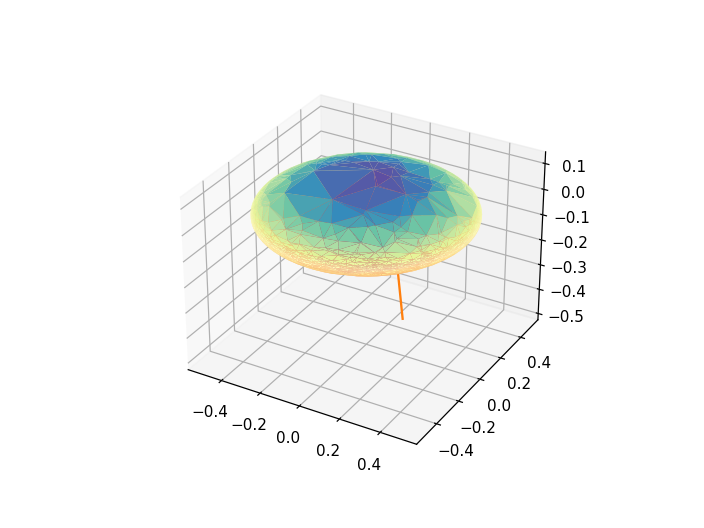

after update_grid
(2500, 3)
projected point:  [ 0.03217049  0.18369093 -0.1182718 ]
normal:  [ 0.01628995  0.06462847 -0.39440816]
vel:  [ 0.14568047  0.8318237  -0.53558055]


In [3]:
# visualize the velocity and friction in 2D
import matplotlib
%matplotlib notebook


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.tri as mtri
import matplotlib as mpl
from IPython import display

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
transform = [0,0,0]
shape = 0.4
cylinder = CylinderSlider(transform, shape)
n_samples = 2500
cylinder.construct_ls_db(n_samples, ax)
f = np.random.normal(size=(3))
f = f / np.linalg.norm(f)
vel = cylinder.get_ls_vel(f, ax=ax, plot_scale=0.4)
print('vel: ', f)

In [4]:
print('vel: ', vel)
print("f: ", f)

vel:  [ 0.01628995  0.06462847 -0.39440816]
f:  [ 0.14568047  0.8318237  -0.53558055]


In [5]:
f_ = cylinder.get_ls_f(vel)
print(f_/np.linalg.norm(f_))
print(f)

[ 0.01159067  0.91775129 -0.39698644]
[ 0.14568047  0.8318237  -0.53558055]


<IPython.core.display.Javascript object>


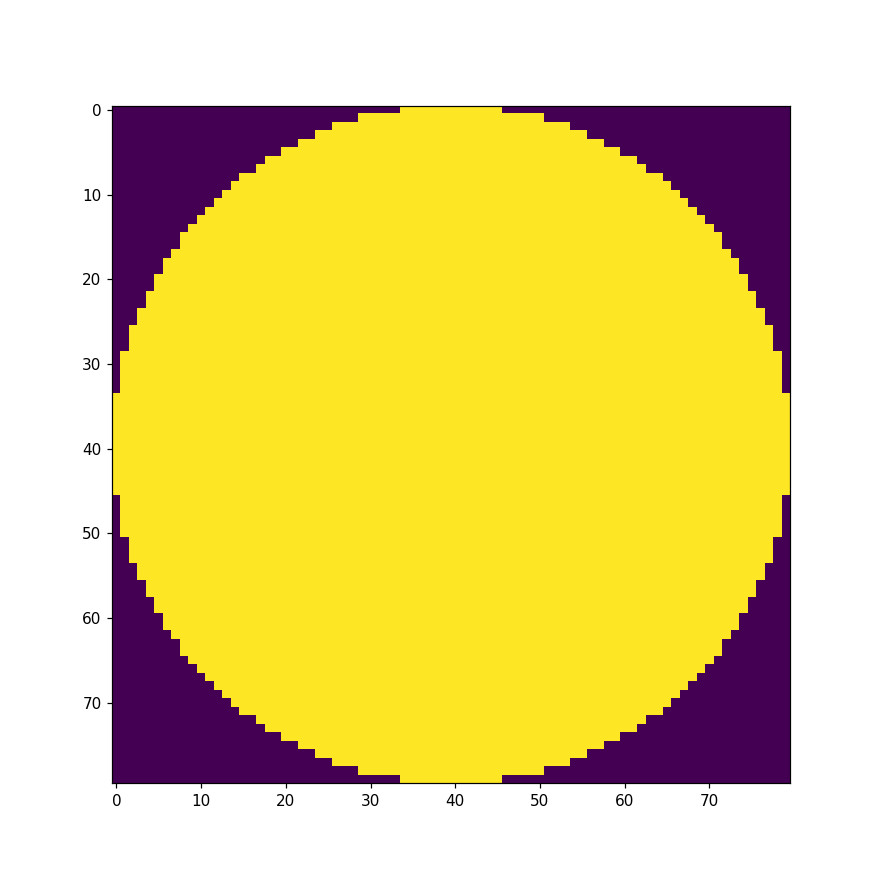

0.785


In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.imshow(cylinder.geo.grid)
print(cylinder.geo.grid.sum()/np.prod(cylinder.geo.grid.shape))

<IPython.core.display.Javascript object>


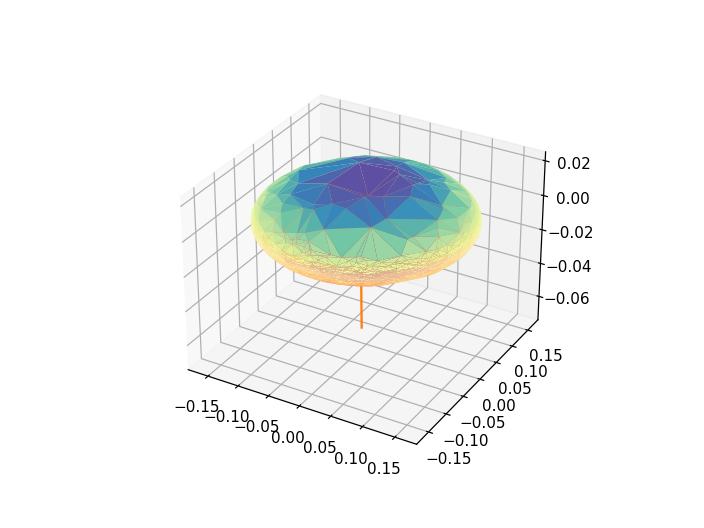

(5000, 3)
projected point:  [-0.02391033  0.02599013 -0.02241449]
normal:  [-0.00012864  0.00224003 -0.04994963]
vel: [-0.00012864  0.00224003 -0.04994963]


In [7]:
# visualize the velocity and friction in 2D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
transform = [0,0,0]
shape = [0.4,0.4]
cylinder = BlockSlider(transform, shape)
n_samples = 5000
cylinder.construct_ls_db(n_samples, ax)
f = np.random.normal(size=(3))
f = f / np.linalg.norm(f)
vel = cylinder.get_ls_vel(f, plot_scale=0.05, ax=ax)
print('vel:', vel)

In [8]:
f_ = cylinder.get_ls_f(vel)
print(f_/np.linalg.norm(f_))
print(f)

[ 0.24281931  0.93385736 -0.2625818 ]
[-0.57163152  0.62135389 -0.53587008]


<IPython.core.display.Javascript object>


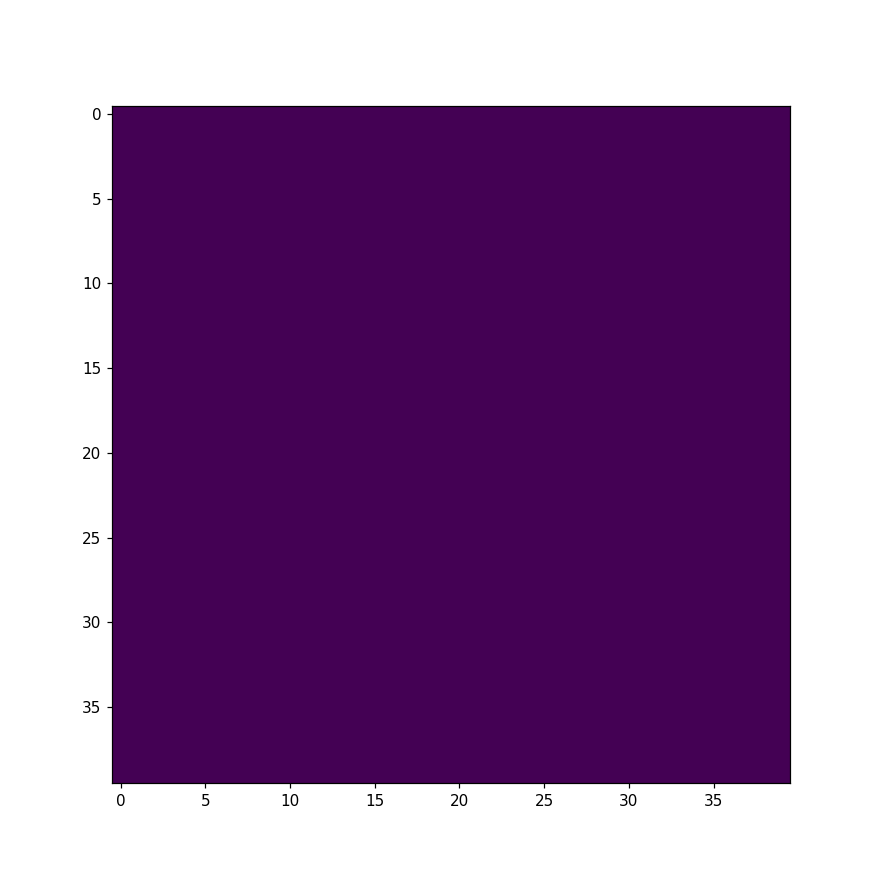

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.imshow(cylinder.geo.grid)
print(cylinder.geo.grid)

<IPython.core.display.Javascript object>


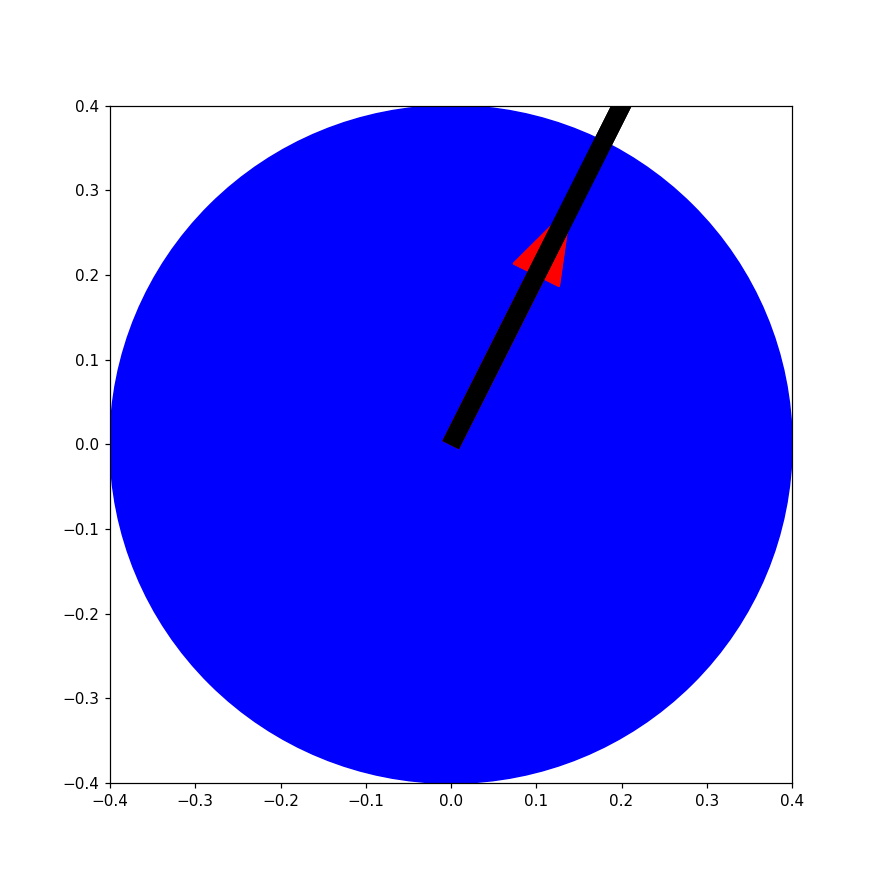

after update_grid


In [10]:
# visualize the velocity and friction in 2D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from IPython import display

def get_ori(slider):
    # get the orientation x0, x1, y0, y1 for the slider
    vec = slider.tf_mat[:2,:2].dot([1,0]) * 0.1
    start_pos = slider.transform[:2]
    end_pos = start_pos + vec
    
    return start_pos, end_pos
fig, ax = plt.subplots(figsize=(8, 8))
transform = [0,0,0]
shape = 0.4
cylinder = CylinderSlider(transform, shape)

ax.set_xlim(transform[0]-shape, transform[0]+shape)
ax.set_ylim(transform[1]-shape, transform[1]+shape)


slider_anim = plt.Circle((cylinder.transform[0],cylinder.transform[1]),
                    cylinder.radius, color='b')
start_ori, end_ori = get_ori(cylinder)
# slider_ori_anim, = ax.plot([start_ori[0], end_ori[0]],
#                                [start_ori[1], end_ori[1]],
#                                color='r')
ax.add_patch(slider_anim)

# plot the velocity
vel = [0.1,0.2,0]
arrow = plt.arrow(transform[0],transform[1], vel[0],vel[1], width=0.02,color='r')
ax.add_patch(arrow)

friction = cylinder.get_total_friction_from_v(vel)
arrow = plt.arrow(transform[0],transform[1], friction[0],friction[1], width=0.02,color='black')
ax.add_patch(arrow)

plt.show()


In [11]:
# visualize the velocity and friction in 2D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from IPython import display

def get_ori(slider):
    # get the orientation x0, x1, y0, y1 for the slider
    vec = slider.tf_mat[:2,:2].dot([1,0]) * 0.1
    start_pos = slider.transform[:2]
    end_pos = start_pos + vec
    
    return start_pos, end_pos
transform = [0,0,0]
shape = 0.4
cylinder = CylinderSlider(transform, shape)



after update_grid


<IPython.core.display.Javascript object>


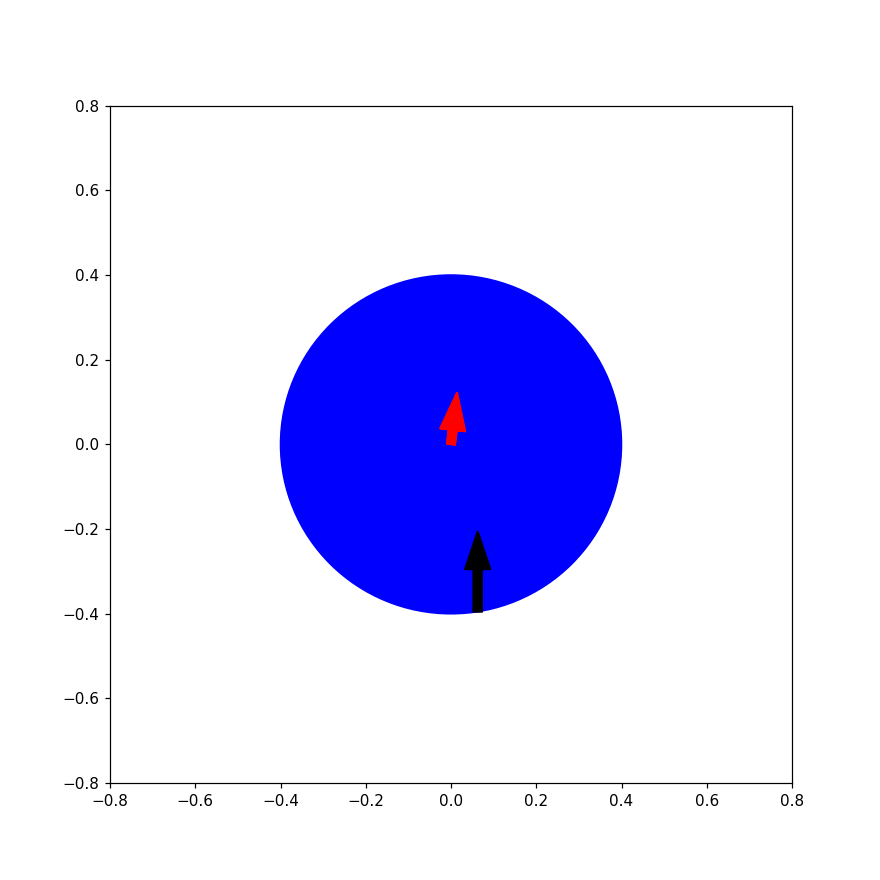

friction:  [0.         0.1        0.01564345]
constructing hull...
(2500, 3)
projected point:  [0.         0.40527984 0.06339973]
normal:  [0.00390055 0.03372382 0.0940611 ]
vel:  [0.00390055 0.03372382 0.0940611 ]


In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(transform[0]-shape*2, transform[0]+shape*2)
ax.set_ylim(transform[1]-shape*2, transform[1]+shape*2)


slider_anim = plt.Circle((cylinder.transform[0],cylinder.transform[1]),
                    cylinder.radius, color='b')
start_ori, end_ori = get_ori(cylinder)
# slider_ori_anim, = ax.plot([start_ori[0], end_ori[0]],
#                                [start_ori[1], end_ori[1]],
#                                color='r')
ax.add_patch(slider_anim)

# plot the impact force
force = [0,0.1,0]
contact_angle = np.pi/2*3.1
contact_pt = [transform[0]+np.cos(contact_angle), transform[1]+np.sin(contact_angle)]
force = np.array(force)
contact_pt = np.array(contact_pt)
friction = cylinder.get_total_friction_at_pt(force, contact_pt)
print('friction: ', friction)
arrow = plt.arrow(transform[0]+shape*np.cos(contact_angle),transform[1]+shape*np.sin(contact_angle), 
                  force[0],force[1], width=0.02,color='black')
ax.add_patch(arrow)

# vel = [0.1,0.2,0]
vel = cylinder.get_ls_vel(friction)
print('vel: ', vel)
# friction = cylinder.get_total_friction_from_v(vel)
arrow = plt.arrow(transform[0],transform[1], vel[0],vel[1], width=0.02,color='red')
ax.add_patch(arrow)

plt.show()


In [13]:
# visualize the velocity and friction in 2D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from IPython import display

def get_ori(slider):
    # get the orientation x0, x1, y0, y1 for the slider
    vec = slider.tf_mat[:2,:2].dot([1,0]) * 0.1
    start_pos = slider.transform[:2]
    end_pos = start_pos + vec
    
    return start_pos, end_pos
transform = [0,0,0]
shape = np.array([0.3,0.4])
slider = BlockSlider(transform, shape)


<IPython.core.display.Javascript object>


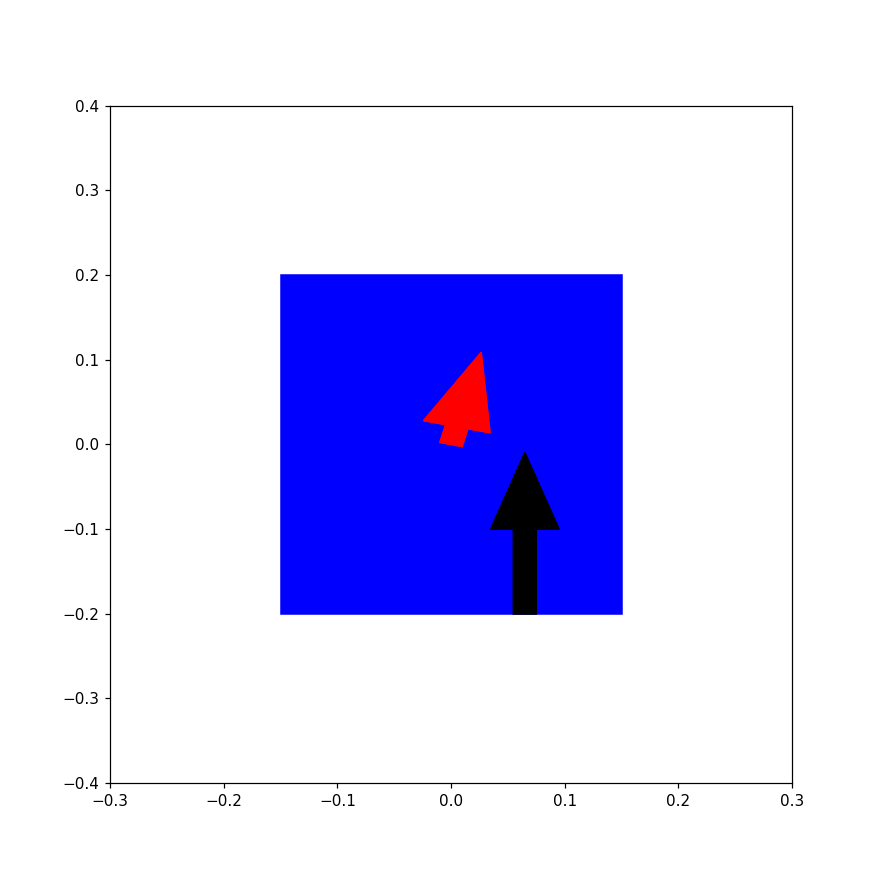

constructing hull...
(2500, 3)
projected point:  [0.         0.10514069 0.00683246]
normal:  [0.00512751 0.02098976 0.09763779]


In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xlim(transform[0]-shape[0], transform[0]+shape[0])
ax.set_ylim(transform[1]-shape[1], transform[1]+shape[1])

contact_angle = np.pi/2*3.2
contact_pt = slider.get_contact_pt(contact_angle)

force = [0,0.1,0]
# contact_pt = [transform[0]+np.cos(contact_angle), transform[1]+np.sin(contact_angle)]
force = np.array(force)
contact_pt = np.array(contact_pt)
friction = slider.get_total_friction_at_pt(force, contact_pt)

slider_anim = plt.Rectangle(slider.transform[:2]-slider.shape/2,
                                 slider.width,
                                 slider.height,
                                 color='b')
transform = slider.transform
t = mpl.transforms.Affine2D().rotate_deg_around(transform[0], transform[1], \
                                                transform[2]/np.pi * 180) + ax.transData
slider_anim.set_transform(t)

start_ori, end_ori = get_ori(slider)
# slider_ori_anim, = ax.plot([start_ori[0], end_ori[0]],
#                                [start_ori[1], end_ori[1]],
#                                color='r')
ax.add_patch(slider_anim)

# plot the velocity
# vel = [0.1,0.2,0]
arrow = plt.arrow(transform[0]+contact_pt[0],transform[1]+contact_pt[1], 
                  force[0],force[1], width=0.02,color='black')
ax.add_patch(arrow)

vel = slider.get_ls_vel(friction)
# friction = slider.get_total_friction_from_v(vel)
arrow = plt.arrow(transform[0],transform[1], vel[0],vel[1], width=0.02,color='red')
ax.add_patch(arrow)

plt.show()


# Now we have a working module to predict point contact -> velocity, and velocity -> friction force. We can predict the slider motion based on a point contact by a pusher.
Next we can use this analytical model to predict the result of pushing. The steps are the following:
1. from the velocity of the pusher, transform the velocity to force, and obtain the velocity of the slider
2. simulate the slider. Find the next pusher position
3. compare if the pusher is moving accordingly (e.g. if it should be straight and it's not)

**quasi-static: assume previous velocity no longer has effect on the object. The slider is not influenced by its previous velocities.**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from IPython import display
"""
implement the animation for the pusher-slider system
"""
class SystemAnimationRelativePusher:
    def __init__(self, slider: Slider, pusher_contact_angle, pusher_rel_vel, dt):
        self.system = System(slider, dt)
        self.pusher_contact_angle = pusher_contact_angle
        self.pusher_rel_vel = pusher_rel_vel
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
    
    def get_ori(self):
        # get the orientation x0, x1, y0, y1 for the slider
        vec = self.system.slider.tf_mat[:2,:2].dot([1,0]) * 0.1
        start_pos = self.system.slider.transform[:2]
        end_pos = start_pos + vec
        return start_pos, end_pos

    def init_anim(self):
        # plot the slider at the start position
        if self.system.slider.type == 'cylinder':
            self.slider_anim = plt.Circle((self.system.slider.transform[0],self.system.slider.transform[1]),
                                self.system.slider.radius, color='b')
            start_ori, end_ori = self.get_ori()
            self.slider_ori_anim, = self.ax.plot([start_ori[0], end_ori[0]],
                                           [start_ori[1], end_ori[1]],
                                           color='r')
        else:
            self.slider_anim = plt.Rectangle(self.system.slider.transform[:2]-self.system.slider.shape/2,
                                             self.system.slider.width,
                                             self.system.slider.height,
                                             color='b')
            transform = self.system.slider.transform
            t = mpl.transforms.Affine2D().rotate_deg_around(transform[0], transform[1], \
                                                            transform[2]/np.pi * 180) + self.ax.transData
            self.slider_anim.set_transform(t)
            start_ori, end_ori = self.get_ori()
            self.slider_ori_anim, = self.ax.plot([start_ori[0], end_ori[0]],
                                           [start_ori[1], end_ori[1]],
                                           color='r')
            
        # plot the pusher
        # get the transform of the pusher in the world frame
        pusher_pt = self.system.slider.get_contact_pt_in_world(self.pusher_contact_angle)
        self.pusher_anim = plt.Circle((pusher_pt[0], pusher_pt[1]), 0.01, color='green')
        self.ax.set_xlim(-2, 2)
        self.ax.set_ylim(-2, 2)

        self.ax.add_patch(self.slider_anim)
        self.ax.add_patch(self.pusher_anim)
        return self.slider_anim, self.pusher_anim, self.slider_ori_anim, 
    def step(self, i):
        print('step: ', i)
        # update the slider based on the pusher
        self.system.update_slider(self.pusher_contact_angle, self.pusher_rel_vel)
        if self.system.slider.type == 'cylinder':
            self.slider_anim.center = self.system.slider.transform[0],self.system.slider.transform[1]
        else:
            transform = self.system.slider.transform
            self.slider_anim.set_xy([transform[0]-self.system.slider.width/2, 
                                     transform[1]-self.system.slider.height/2])
            t = mpl.transforms.Affine2D().rotate_deg_around(transform[0], transform[1], \
                                                            transform[2]/np.pi * 180) + self.ax.transData
            self.slider_anim.set_transform(t)      
        start_ori, end_ori = self.get_ori()
#         print('start ori: ', start_ori)
#         print('start ori: ', start_ori)

        self.slider_ori_anim.set_xdata([start_ori[0], end_ori[0]])
        self.slider_ori_anim.set_ydata([start_ori[1], end_ori[1]])

        # get the relative position again
        pusher_pt = self.system.slider.get_contact_pt_in_world(self.pusher_contact_angle)
        self.pusher_anim.center = pusher_pt[0],pusher_pt[1]
        
        return self.slider_anim, self.pusher_anim,
    def anim(self):
        ani = FuncAnimation(self.fig, self.step, frames=np.arange(0,400,1),
                            init_func=self.init_anim, interval=int(1000*dt), blit=False)
        video = ani.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()


<IPython.core.display.Javascript object>


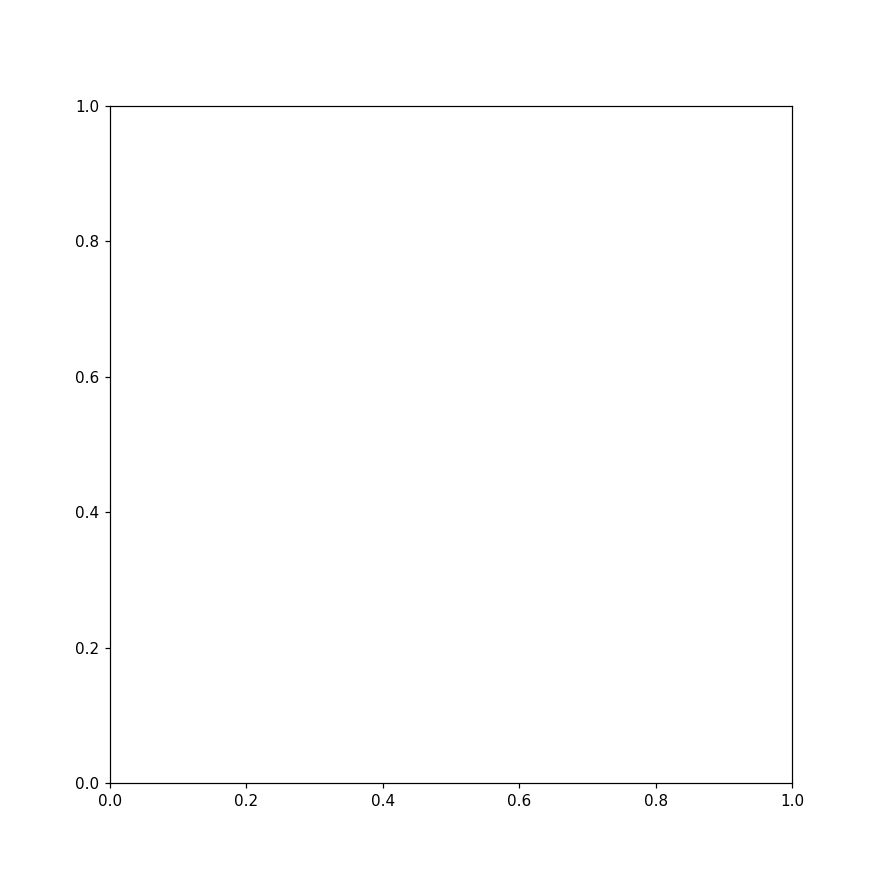

In [16]:
# slider = CylinderSlider([0,0,0], 0.2)
slider = BlockSlider([0,0,0], [0.2,0.2])

pusher_contact_angle = 3/2*np.pi + 30*np.pi/180
pusher_rel_vel = np.array([0,0.1])
dt = 0.01
anim = SystemAnimationRelativePusher(slider, pusher_contact_angle, pusher_rel_vel, dt)
# anim.anim()

# Now we implement a simulator for a pusher pushing a slider. The pusher is independent of the slider, and follows an open-loop trajectory.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from IPython import display
"""
implement the animation for the pusher-slider system
"""
class SystemAnimationPusher:
    def __init__(self, slider: Slider, pusher_start, pusher_vels, pusher_durs, dt):
        self.system = System(slider, dt)
        self.pusher_start = pusher_start
        self.pusher_vels = pusher_vels
        self.pusher_durs = pusher_durs
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.pusher_pt = pusher_start
        self.dt = dt
    def get_ori(self):
        # get the orientation x0, x1, y0, y1 for the slider
        vec = self.system.slider.tf_mat[:2,:2].dot([1,0]) * 0.1
        start_pos = self.system.slider.transform[:2]
        end_pos = start_pos + vec
        return start_pos, end_pos

    def init_anim(self):
        # plot the slider at the start position
        if self.system.slider.type == 'cylinder':
            self.slider_anim = plt.Circle((self.system.slider.transform[0],self.system.slider.transform[1]),
                                self.system.slider.radius, color='b')
            start_ori, end_ori = self.get_ori()
            self.slider_ori_anim, = self.ax.plot([start_ori[0], end_ori[0]],
                                           [start_ori[1], end_ori[1]],
                                           color='r')
        else:
            self.slider_anim = plt.Rectangle(self.system.slider.transform[:2]-self.system.slider.shape/2,
                                             self.system.slider.width,
                                             self.system.slider.height,
                                             color='b')
            transform = self.system.slider.transform
            t = mpl.transforms.Affine2D().rotate_deg_around(transform[0], transform[1], \
                                                            transform[2]/np.pi * 180) + self.ax.transData
            self.slider_anim.set_transform(t)
            start_ori, end_ori = self.get_ori()
            self.slider_ori_anim, = self.ax.plot([start_ori[0], end_ori[0]],
                                           [start_ori[1], end_ori[1]],
                                           color='r')
            
        # plot the pusher
        # get the transform of the pusher in the world frame
        self.pusher_pt = self.pusher_start
        self.pusher_anim = plt.Circle((self.pusher_start[0], self.pusher_start[1]), 0.01, color='red')
        self.ax.set_xlim(-2, 2)
        self.ax.set_ylim(-2, 2)

        self.ax.add_patch(self.slider_anim)
        self.ax.add_patch(self.pusher_anim)
        return self.slider_anim, self.pusher_anim, self.slider_ori_anim, 
    def step(self, i):
        print('step: ', i)
        # update the slider based on the pusher
        # compute the pusher contact angle
        pusher_contact_angle = self.system.slider.get_contact_angle_from_global(self.pusher_pt)
        print('pusher_contact_angle: ', pusher_contact_angle)
        # check if the pusher is at the boundary of the slider
        if self.system.slider.global_inside(self.pusher_pt):
            # convert the pusher_vel to the frame of the slider
            print('pusher inside the slider')
            rel_vel = self.system.get_vel_in_local(self.pusher_vels[0])
            self.system.update_slider(pusher_contact_angle, rel_vel)
        if self.system.slider.type == 'cylinder':
            self.slider_anim.center = self.system.slider.transform[0],self.system.slider.transform[1]
        else:
            transform = self.system.slider.transform
            self.slider_anim.set_xy([transform[0]-self.system.slider.width/2, 
                                     transform[1]-self.system.slider.height/2])
            t = mpl.transforms.Affine2D().rotate_deg_around(transform[0], transform[1], \
                                                            transform[2]/np.pi * 180) + self.ax.transData
            self.slider_anim.set_transform(t)      
        start_ori, end_ori = self.get_ori()
#         print('start ori: ', start_ori)
#         print('start ori: ', start_ori)

        self.slider_ori_anim.set_xdata([start_ori[0], end_ori[0]])
        self.slider_ori_anim.set_ydata([start_ori[1], end_ori[1]])

        # get the relative position again
        self.pusher_pt = self.pusher_pt + pusher_vels[0] * self.dt
        print('new pusher_pt: ', self.pusher_pt)
        self.pusher_anim.center = self.pusher_pt[0],self.pusher_pt[1]
        
        return self.slider_anim, self.pusher_anim,
    def anim(self):
        ani = FuncAnimation(self.fig, self.step, frames=np.arange(0,800,1),
                            init_func=self.init_anim, interval=int(1000*dt), blit=False)
        video = ani.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()


<IPython.core.display.Javascript object>


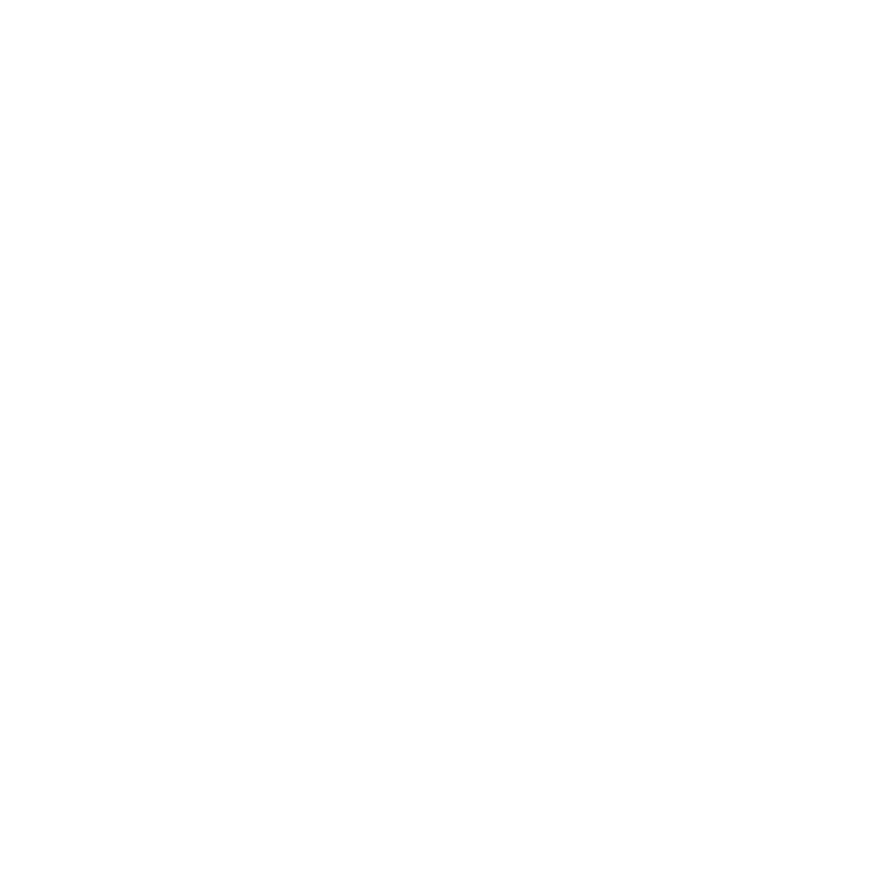

step:  0
pusher_contact_angle:  -1.373400766945016
new pusher_pt:  [ 0.04   -0.1995]
step:  1
pusher_contact_angle:  -1.3729188392714824
new pusher_pt:  [ 0.04  -0.199]
step:  2
pusher_contact_angle:  -1.372434583670784
new pusher_pt:  [ 0.04   -0.1985]
step:  3
pusher_contact_angle:  -1.3719479834634567
new pusher_pt:  [ 0.04  -0.198]
step:  4
pusher_contact_angle:  -1.3714590218125726
new pusher_pt:  [ 0.04   -0.1975]
step:  5
pusher_contact_angle:  -1.3709676817219063
new pusher_pt:  [ 0.04  -0.197]
step:  6
pusher_contact_angle:  -1.370473946034075
new pusher_pt:  [ 0.04   -0.1965]
step:  7
pusher_contact_angle:  -1.3699777974286518
new pusher_pt:  [ 0.04  -0.196]
step:  8
pusher_contact_angle:  -1.3694792184202558
new pusher_pt:  [ 0.04   -0.1955]
step:  9
pusher_contact_angle:  -1.3689781913566135
new pusher_pt:  [ 0.04  -0.195]
step:  10
pusher_contact_angle:  -1.368474698416593
new pusher_pt:  [ 0.04   -0.1945]
step:  11
pusher_contact_angle:  -1.3679687216082126
new pusher_pt:

step:  104
pusher_contact_angle:  -1.306832603169192
new pusher_pt:  [ 0.04   -0.1475]
step:  105
pusher_contact_angle:  -1.3059789968891078
new pusher_pt:  [ 0.04  -0.147]
step:  106
pusher_contact_angle:  -1.3051199828192857
new pusher_pt:  [ 0.04   -0.1465]
step:  107
pusher_contact_angle:  -1.3042555106869385
new pusher_pt:  [ 0.04  -0.146]
step:  108
pusher_contact_angle:  -1.303385529611023
new pusher_pt:  [ 0.04   -0.1455]
step:  109
pusher_contact_angle:  -1.3025099880932927
new pusher_pt:  [ 0.04  -0.145]
step:  110
pusher_contact_angle:  -1.3016288340091962
new pusher_pt:  [ 0.04   -0.1445]
step:  111
pusher_contact_angle:  -1.3007420145986204
new pusher_pt:  [ 0.04  -0.144]
step:  112
pusher_contact_angle:  -1.299849476456476
new pusher_pt:  [ 0.04   -0.1435]
step:  113
pusher_contact_angle:  -1.2989511655231194
new pusher_pt:  [ 0.04  -0.143]
step:  114
pusher_contact_angle:  -1.2980470270746114
new pusher_pt:  [ 0.04   -0.1425]
step:  115
pusher_contact_angle:  -1.29713700

step:  200
pusher_contact_angle:  -1.1902899496825314
pusher inside the slider
input pusher_rel_vel:  [0.  0.1]
contact_angle:  -1.1902899496825314
norm:  [-0.  1.]
projection:  0.1
pusher_rel_vel:  [-0.   0.1]
constructing hull...
(2500, 3)
projected point:  [-0.          0.03372295  0.00134892]
normal:  [-0.0030131   0.01208009  0.09922194]
slider velocity:  [-0.01724432  0.06913583  0.56785941]
pusher velocity:  [-0.   0.1]
contact velocity:  [0.0069091  0.01604896]
new contact point:  [ 0.03999984 -0.0994996 ]
new pusher_pt:  [ 0.04   -0.0995]
step:  201
pusher_contact_angle:  -1.1902899496825314
pusher inside the slider
input pusher_rel_vel:  [0.00028393 0.0999996 ]
contact_angle:  -1.1902899496825314
norm:  [-0.  1.]
projection:  0.09999959691988614
pusher_rel_vel:  [-0.         0.0999996]
projected point:  [-0.          0.03372295  0.00134892]
normal:  [-0.0030131   0.01208009  0.09922194]
slider velocity:  [-0.01722316  0.06905097  0.56716239]
pusher velocity:  [-0.         0.0

step:  217
pusher_contact_angle:  -1.1868738151118852
pusher inside the slider
input pusher_rel_vel:  [0.00449389 0.09989897]
contact_angle:  -1.1868738151118852
norm:  [-0.  1.]
projection:  0.09989897393146706
pusher_rel_vel:  [-0.          0.09989897]
projected point:  [-0.          0.03364042  0.00135897]
normal:  [-0.0030131   0.01208009  0.09922194]
slider velocity:  [-0.01686917  0.06763175  0.55550538]
pusher velocity:  [-0.          0.09989897]
contact velocity:  [0.00671895 0.01653018]
new contact point:  [ 0.04021085 -0.09151048]
new pusher_pt:  [ 0.04  -0.091]
step:  218
pusher_contact_angle:  -1.1866657276219847
pusher inside the slider
input pusher_rel_vel:  [0.00477134 0.09988611]
contact_angle:  -1.1866657276219847
norm:  [-0.  1.]
projection:  0.09988610671655666
pusher_rel_vel:  [-0.          0.09988611]
projected point:  [-0.          0.0336354   0.00135958]
normal:  [-0.0030131   0.01208009  0.09922194]
slider velocity:  [-0.0168457   0.06753768  0.55473275]
pusher 

slider velocity:  [0.00569835 0.04753011 0.59575781]
pusher velocity:  [-0.          0.09957888]
contact velocity:  [0.01050502 0.01293183]
new contact point:  [ 0.04022653 -0.08352338]
new pusher_pt:  [ 0.04  -0.083]
step:  234
pusher_contact_angle:  -1.1816415617589335
pusher inside the slider
input pusher_rel_vel:  [0.00946433 0.09955113]
contact_angle:  -1.1816415617589335
norm:  [-0.  1.]
projection:  0.09955112518338265
pusher_rel_vel:  [-0.          0.09955113]
projected point:  [-0.          0.03347909  0.00137287]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00569125 0.04747094 0.59501612]
pusher velocity:  [-0.          0.09955113]
contact velocity:  [0.01048969 0.012965  ]
new contact point:  [ 0.04022763 -0.08302405]
new pusher_pt:  [ 0.04   -0.0825]
step:  235
pusher_contact_angle:  -1.181219499347436
pusher inside the slider
input pusher_rel_vel:  [0.00976046 0.09952253]
contact_angle:  -1.181219499347436
norm:  [-0.  1.]
projection:  0.099522527522387

step:  250
pusher_contact_angle:  -1.1733995792449843
pusher inside the slider
input pusher_rel_vel:  [0.01414481 0.09899457]
contact_angle:  -1.1733995792449843
norm:  [-0.  1.]
projection:  0.09899456673311946
pusher_rel_vel:  [-0.          0.09899457]
projected point:  [-0.          0.03321345  0.00139406]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00557125 0.04646996 0.58246955]
pusher velocity:  [-0.          0.09899457]
contact velocity:  [0.01022928 0.01350413]
new contact point:  [ 0.04024695 -0.07503341]
new pusher_pt:  [ 0.04   -0.0745]
step:  251
pusher_contact_angle:  -1.172780682831601
pusher inside the slider
input pusher_rel_vel:  [0.01443306 0.09895295]
contact_angle:  -1.172780682831601
norm:  [-0.  1.]
projection:  0.0989529523506801
pusher_rel_vel:  [-0.          0.09895295]
projected point:  [-0.          0.0331936   0.00139565]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00556337 0.04640425 0.58164598]
pusher velocity:  [-

step:  267
pusher_contact_angle:  -1.1612805480718114
pusher inside the slider
input pusher_rel_vel:  [0.01897034 0.09818414]
contact_angle:  -1.1612805480718114
norm:  [-0.  1.]
projection:  0.09818414337772795
pusher_rel_vel:  [-0.          0.09818414]
projected point:  [-0.          0.03282715  0.00142488]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00543213 0.04530956 0.56792473]
pusher velocity:  [-0.          0.09818414]
contact velocity:  [0.00991951 0.01409145]
new contact point:  [ 0.04027108 -0.06653998]
new pusher_pt:  [ 0.04  -0.066]
step:  268
pusher_contact_angle:  -1.1604642865751924
pusher inside the slider
input pusher_rel_vel:  [0.01924907 0.09812988]
contact_angle:  -1.1604642865751924
norm:  [-0.  1.]
projection:  0.09812987895814212
pusher_rel_vel:  [-0.          0.09812988]
projected point:  [-0.          0.03280131  0.00142694]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00542363 0.04523865 0.56703597]
pusher velocity:  [

step:  285
pusher_contact_angle:  -1.1449202412131332
pusher inside the slider
input pusher_rel_vel:  [0.02389463 0.09710328]
contact_angle:  -1.1449202412131332
norm:  [-0.  1.]
projection:  0.09710327846307694
pusher_rel_vel:  [-0.          0.09710328]
projected point:  [-0.          0.03231345  0.00146586]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00527461 0.04399574 0.55145695]
pusher velocity:  [-0.          0.09710328]
contact velocity:  [0.00955207 0.01472508]
new contact point:  [ 0.04030016 -0.05754276]
new pusher_pt:  [ 0.04  -0.057]
step:  286
pusher_contact_angle:  -1.1439108888454887
pusher inside the slider
input pusher_rel_vel:  [0.02416228 0.09703703]
contact_angle:  -1.1439108888454887
norm:  [-0.  1.]
projection:  0.09703702513002804
pusher_rel_vel:  [-0.          0.09703703]
projected point:  [-0.          0.03228204  0.00146837]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00526561 0.04392065 0.55051572]
pusher velocity:  [

step:  302
pusher_contact_angle:  -1.1264148822582178
pusher inside the slider
input pusher_rel_vel:  [0.0283562  0.09589539]
contact_angle:  -1.1264148822582178
norm:  [-0.  1.]
projection:  0.0958953899154408
pusher_rel_vel:  [-0.          0.09589539]
projected point:  [-0.          0.03174261  0.00151141]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00511867 0.04269499 0.53515292]
pusher velocity:  [-0.          0.09589539]
contact velocity:  [0.00916632 0.0153303 ]
new contact point:  [ 0.04033045 -0.0490412 ]
new pusher_pt:  [ 0.04   -0.0485]
step:  303
pusher_contact_angle:  -1.1252403457966487
pusher inside the slider
input pusher_rel_vel:  [0.02861269 0.09581917]
contact_angle:  -1.1252403457966487
norm:  [-0.  1.]
projection:  0.0958191721927431
pusher_rel_vel:  [-0.          0.09581917]
projected point:  [-0.          0.03170673  0.00151427]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00510932 0.04261706 0.53417603]
pusher velocity:  [

step:  319
pusher_contact_angle:  -1.1052464476517176
pusher inside the slider
input pusher_rel_vel:  [0.03262416 0.09452864]
contact_angle:  -1.1052464476517176
norm:  [-0.  1.]
projection:  0.09452864123494055
pusher_rel_vel:  [-0.          0.09452864]
projected point:  [-0.          0.03110209  0.00156251]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00495785 0.0413536  0.51833942]
pusher velocity:  [-0.          0.09452864]
contact velocity:  [0.0087422  0.01593807]
new contact point:  [ 0.04036296 -0.04053546]
new pusher_pt:  [ 0.04 -0.04]
step:  320
pusher_contact_angle:  -1.103925113955637
pusher inside the slider
input pusher_rel_vel:  [0.03286904 0.09444377]
contact_angle:  -1.103925113955637
norm:  [-0.  1.]
projection:  0.09444377191275566
pusher_rel_vel:  [-0.          0.09444377]
projected point:  [-0.          0.03106253  0.00156566]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00494828 0.04127376 0.51733867]
pusher velocity:  [-0. 

step:  338
pusher_contact_angle:  -1.0788340065797823
pusher inside the slider
input pusher_rel_vel:  [0.03715769 0.09284022]
contact_angle:  -1.0788340065797823
norm:  [-0.  1.]
projection:  0.09284021680487392
pusher_rel_vel:  [-0.          0.09284022]
projected point:  [-0.          0.03032015  0.00162489]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00477454 0.03982459 0.4991743 ]
pusher velocity:  [-0.          0.09284022]
contact velocity:  [0.00822268 0.01661572]
new contact point:  [ 0.04040134 -0.03102406]
new pusher_pt:  [ 0.04   -0.0305]
step:  339
pusher_contact_angle:  -1.0773718459613093
pusher inside the slider
input pusher_rel_vel:  [0.03738929 0.09274719]
contact_angle:  -1.0773718459613093
norm:  [-0.  1.]
projection:  0.09274718690664935
pusher_rel_vel:  [-0.          0.09274719]
projected point:  [-0.          0.03027739  0.0016283 ]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00476482 0.03974357 0.49815883]
pusher velocity: 

step:  356
pusher_contact_angle:  -1.0515462584311317
pusher inside the slider
input pusher_rel_vel:  [0.04121881 0.09110988]
contact_angle:  -1.0515462584311317
norm:  [-0.  1.]
projection:  0.09110987674241125
pusher_rel_vel:  [-0.          0.09110988]
projected point:  [-0.          0.02953069  0.00168788]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00459925 0.03836247 0.48084763]
pusher velocity:  [-0.          0.09110988]
contact velocity:  [0.00768677 0.0172519 ]
new contact point:  [ 0.04043915 -0.02200848]
new pusher_pt:  [ 0.04   -0.0215]
step:  357
pusher_contact_angle:  -1.0499741773888018
pusher inside the slider
input pusher_rel_vel:  [0.04143774 0.09101051]
contact_angle:  -1.0499741773888018
norm:  [-0.  1.]
projection:  0.09101051367727031
pusher_rel_vel:  [-0.          0.09101051]
projected point:  [-0.          0.02948574  0.00169146]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00458949 0.03828112 0.47982801]
pusher velocity: 

step:  374
pusher_contact_angle:  -1.022476316660043
pusher inside the slider
input pusher_rel_vel:  [0.0450523  0.08927648]
contact_angle:  -1.022476316660043
norm:  [-0.  1.]
projection:  0.0892764819428583
pusher_rel_vel:  [-0.          0.08927648]
projected point:  [-0.          0.02870826  0.00175349]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.0044239  0.03689994 0.46251582]
pusher velocity:  [-0.          0.08927648]
contact velocity:  [0.00710944 0.01787867]
new contact point:  [ 0.0404779 -0.0129884]
new pusher_pt:  [ 0.04   -0.0125]
step:  375
pusher_contact_angle:  -1.02081740060435
pusher inside the slider
input pusher_rel_vel:  [0.04525864 0.08917206]
contact_angle:  -1.02081740060435
norm:  [-0.  1.]
projection:  0.08917205630096443
pusher_rel_vel:  [-0.          0.08917206]
projected point:  [-0.          0.02866186  0.00175719]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00441419 0.03681889 0.46149997]
pusher velocity:  [-0.    

step:  389
pusher_contact_angle:  -0.9971882305305049
pusher inside the slider
input pusher_rel_vel:  [0.0480748  0.08768588]
contact_angle:  -0.9971882305305049
norm:  [-0.  1.]
projection:  0.0876858827460203
pusher_rel_vel:  [-0.          0.08768588]
projected point:  [-0.          0.0280069   0.00180944]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00427865 0.03568839 0.44732986]
pusher velocity:  [-0.          0.08768588]
contact velocity:  [0.00659784 0.01839142]
new contact point:  [ 0.04051064 -0.00546836]
new pusher_pt:  [ 0.04  -0.005]
step:  390
pusher_contact_angle:  -0.99547431340356
pusher inside the slider
input pusher_rel_vel:  [0.0482708  0.08757814]
contact_angle:  -0.99547431340356
norm:  [-0.  1.]
projection:  0.0875781370487946
pusher_rel_vel:  [-0.          0.08757814]
projected point:  [-0.          0.02795981  0.0018132 ]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00426901 0.03560799 0.44632215]
pusher velocity:  [-0.   

step:  406
pusher_contact_angle:  -0.9676729714763627
pusher inside the slider
input pusher_rel_vel:  [0.05131474 0.08583005]
contact_angle:  -0.9676729714763627
norm:  [-0.  1.]
projection:  0.08583004878722965
pusher_rel_vel:  [-0.          0.08583005]
projected point:  [-0.          0.02720316  0.00187357]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00411579 0.03432995 0.43030276]
pusher velocity:  [-0.          0.08583005]
contact velocity:  [0.00598599 0.01895985]
new contact point:  [0.04054799 0.00305782]
new pusher_pt:  [0.04   0.0035]
step:  407
pusher_contact_angle:  -0.9659150776583376
pusher inside the slider
input pusher_rel_vel:  [0.05149929 0.08571945]
contact_angle:  -0.9659150776583376
norm:  [-0.  1.]
projection:  0.08571944584234709
pusher_rel_vel:  [-0.          0.08571945]
projected point:  [-0.          0.02715575  0.00187735]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00410628 0.03425065 0.42930883]
pusher velocity:  [-0

projected point:  [-0.          0.02644507  0.00193405]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00396483 0.03307079 0.41452005]
pusher velocity:  [-0.          0.08404526]
contact velocity:  [0.00538062 0.01948077]
new contact point:  [0.04058322 0.01108564]
new pusher_pt:  [0.04   0.0115]
step:  423
pusher_contact_angle:  -0.9375589432118442
pusher inside the slider
input pusher_rel_vel:  [0.05436258 0.08393277]
contact_angle:  -0.9375589432118442
norm:  [-0.  1.]
projection:  0.08393276706372421
pusher_rel_vel:  [-0.          0.08393277]
projected point:  [-0.          0.02639778  0.00193782]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00395548 0.03299282 0.41354272]
pusher velocity:  [-0.          0.08393277]
contact velocity:  [0.00534187 0.01951284]
new contact point:  [0.04058542 0.01158748]
new pusher_pt:  [0.04  0.012]
step:  424
pusher_contact_angle:  -0.9357754368702272
pusher inside the slider
input pusher_rel_vel:  [0.05453602 0

<ipython-input-2-47825476114b>:331: RuntimeWarning: invalid value encountered in divide
  friction = friction / np.linalg.norm(friction)


step:  431
pusher_contact_angle:  -0.921253238868837
pusher inside the slider
input pusher_rel_vel:  [0.05556286 0.08314306]
contact_angle:  -0.921253238868837
norm:  [-0.  1.]
projection:  0.08314306362185117
pusher_rel_vel:  [-0.          0.08314306]
projected point:  [-0.          0.02596725  0.00197217]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00388278 0.03238642 0.40594191]
pusher velocity:  [-0.          0.08314306]
contact velocity:  [0.00503466 0.01978519]
new contact point:  [0.04109878 0.01543244]
new pusher_pt:  [0.04  0.016]
step:  432
pusher_contact_angle:  -0.9194584138306737
pusher inside the slider
input pusher_rel_vel:  [0.0557315  0.08303012]
contact_angle:  -0.9194584138306737
norm:  [-0.  1.]
projection:  0.08303011597756671
pusher_rel_vel:  [-0.          0.08303012]
projected point:  [-0.          0.02592008  0.00197593]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00387353 0.03230922 0.40497428]
pusher velocity:  [-0.   

step:  449
pusher_contact_angle:  -0.8889130269444491
pusher inside the slider
input pusher_rel_vel:  [0.05850311 0.08110108]
contact_angle:  -0.8889130269444491
norm:  [-0.  1.]
projection:  0.0811010828290723
pusher_rel_vel:  [-0.          0.08110108]
projected point:  [-0.          0.02512354  0.00203948]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00371805 0.03101242 0.38871978]
pusher velocity:  [-0.          0.08110108]
contact velocity:  [0.00430355 0.02034646]
new contact point:  [0.04117677 0.02449567]
new pusher_pt:  [0.04  0.025]
step:  450
pusher_contact_angle:  -0.8871172659027179
pusher inside the slider
input pusher_rel_vel:  [0.05866063 0.08098722]
contact_angle:  -0.8871172659027179
norm:  [-0.  1.]
projection:  0.0809872231290323
pusher_rel_vel:  [-0.          0.08098722]
projected point:  [-0.          0.02507706  0.00204319]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00370902 0.0309371  0.38777562]
pusher velocity:  [-0.   

step:  466
pusher_contact_angle:  -0.8504611125897025
pusher inside the slider
input pusher_rel_vel:  [0.06050048 0.07962219]
contact_angle:  -0.8504611125897025
norm:  [-0.  1.]
projection:  0.07962218604956489
pusher_rel_vel:  [-0.          0.07962219]
projected point:  [-0.          0.02413567  0.00211829]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00357147 0.02978978 0.37339476]
pusher velocity:  [-0.          0.07962219]
contact velocity:  [0.00359722 0.02094875]
new contact point:  [0.04335131 0.03263789]
new pusher_pt:  [0.04   0.0335]
step:  467
pusher_contact_angle:  -0.8486612421743556
pusher inside the slider
input pusher_rel_vel:  [0.06064902 0.07950909]
contact_angle:  -0.8486612421743556
norm:  [-1. -0.]
projection:  0
pusher_rel_vel:  [-0. -0.]
projected point:  [nan nan nan]
normal:  [-0.00033665 -0.00286878  0.09995828]
slider velocity:  [-0. -0.  0.]
pusher velocity:  [-0. -0.]
contact velocity:  [0.00227089 0.01019425]
new contact point:  [0.043

step:  482
pusher_contact_angle:  -0.8177807155689382
pusher inside the slider
input pusher_rel_vel:  [0.06252157 0.0780452 ]
contact_angle:  -0.8177807155689382
norm:  [-0.  1.]
projection:  0.07804520340608384
pusher_rel_vel:  [-0.         0.0780452]
projected point:  [-0.          0.02330682  0.00218442]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00343381 0.02864156 0.35900258]
pusher velocity:  [-0.         0.0780452]
contact velocity:  [0.00289188 0.02147578]
new contact point:  [0.04465721 0.04065657]
new pusher_pt:  [0.04   0.0415]
step:  483
pusher_contact_angle:  -0.8159970372601595
pusher inside the slider
input pusher_rel_vel:  [0.06266156 0.07793285]
contact_angle:  -0.8159970372601595
norm:  [-0.  1.]
projection:  0.0779328507160256
pusher_rel_vel:  [-0.          0.07793285]
projected point:  [-0.          0.02326183  0.00218801]
normal:  [0.00095341 0.00795246 0.09967873]
slider velocity:  [0.00342519 0.02856963 0.35810101]
pusher velocity:  [-0.    

new pusher_pt:  [0.04   0.0505]
step:  501
pusher_contact_angle:  -0.774546670642981
pusher inside the slider
input pusher_rel_vel:  [0.06443054 0.07647683]
contact_angle:  -0.774546670642981
norm:  [-1. -0.]
projection:  0
pusher_rel_vel:  [-0. -0.]
projected point:  [nan nan nan]
normal:  [-0.00033665 -0.00286878  0.09995828]
slider velocity:  [-0. -0.  0.]
pusher velocity:  [-0. -0.]
contact velocity:  [0.00070334 0.0110778 ]
new contact point:  [0.04476308 0.05014482]
new pusher_pt:  [0.04  0.051]
step:  502
pusher_contact_angle:  -0.7708559145868561
pusher inside the slider
input pusher_rel_vel:  [0.06443054 0.07647683]
contact_angle:  -0.7708559145868561
norm:  [-1. -0.]
projection:  0
pusher_rel_vel:  [-0. -0.]
projected point:  [nan nan nan]
normal:  [-0.00033665 -0.00286878  0.09995828]
slider velocity:  [-0. -0.  0.]
pusher velocity:  [-0. -0.]
contact velocity:  [0.00064831 0.01103144]
new contact point:  [0.04429926 0.05069536]
new pusher_pt:  [0.04   0.0515]
step:  503
pus

step:  555
pusher_contact_angle:  -0.5749867538154618
new pusher_pt:  [0.04  0.078]
step:  556
pusher_contact_angle:  -0.5713359618605739
new pusher_pt:  [0.04   0.0785]
step:  557
pusher_contact_angle:  -0.5676886185325148
new pusher_pt:  [0.04  0.079]
step:  558
pusher_contact_angle:  -0.5640448158492235
new pusher_pt:  [0.04   0.0795]
step:  559
pusher_contact_angle:  -0.5604046452740101
new pusher_pt:  [0.04 0.08]
step:  560
pusher_contact_angle:  -0.5567681977029286
new pusher_pt:  [0.04   0.0805]
step:  561
pusher_contact_angle:  -0.553135563452362
new pusher_pt:  [0.04  0.081]
step:  562
pusher_contact_angle:  -0.5495068322468284
new pusher_pt:  [0.04   0.0815]
step:  563
pusher_contact_angle:  -0.545882093207011
new pusher_pt:  [0.04  0.082]
step:  564
pusher_contact_angle:  -0.5422614348380119
new pusher_pt:  [0.04   0.0825]
step:  565
pusher_contact_angle:  -0.5386449450178386
new pusher_pt:  [0.04  0.083]
step:  566
pusher_contact_angle:  -0.53503271098612
new pusher_pt:  [0

step:  659
pusher_contact_angle:  -0.2271876803924106
new pusher_pt:  [0.04 0.13]
step:  660
pusher_contact_angle:  -0.2242516199418131
new pusher_pt:  [0.04   0.1305]
step:  661
pusher_contact_angle:  -0.22132441799754035
new pusher_pt:  [0.04  0.131]
step:  662
pusher_contact_angle:  -0.2184060844653905
new pusher_pt:  [0.04   0.1315]
step:  663
pusher_contact_angle:  -0.2154966285870037
new pusher_pt:  [0.04  0.132]
step:  664
pusher_contact_angle:  -0.21259605894669653
new pusher_pt:  [0.04   0.1325]
step:  665
pusher_contact_angle:  -0.20970438347833478
new pusher_pt:  [0.04  0.133]
step:  666
pusher_contact_angle:  -0.20682160947224065
new pusher_pt:  [0.04   0.1335]
step:  667
pusher_contact_angle:  -0.20394774358213175
new pusher_pt:  [0.04  0.134]
step:  668
pusher_contact_angle:  -0.20108279183209016
new pusher_pt:  [0.04   0.1345]
step:  669
pusher_contact_angle:  -0.19822675962355682
new pusher_pt:  [0.04  0.135]
step:  670
pusher_contact_angle:  -0.19537965174235064
new pu

step:  755
pusher_contact_angle:  0.014645673188739087
new pusher_pt:  [0.04  0.178]
step:  756
pusher_contact_angle:  0.016758142046547846
new pusher_pt:  [0.04   0.1785]
step:  757
pusher_contact_angle:  0.0188628608235345
new pusher_pt:  [0.04  0.179]
step:  758
pusher_contact_angle:  0.020959853546258327
new pusher_pt:  [0.04   0.1795]
step:  759
pusher_contact_angle:  0.023049144337005112
new pusher_pt:  [0.04 0.18]
step:  760
pusher_contact_angle:  0.02513075741015448
new pusher_pt:  [0.04   0.1805]
step:  761
pusher_contact_angle:  0.02720471706859686
new pusher_pt:  [0.04  0.181]
step:  762
pusher_contact_angle:  0.029271047700204472
new pusher_pt:  [0.04   0.1815]
step:  763
pusher_contact_angle:  0.031329773774352254
new pusher_pt:  [0.04  0.182]
step:  764
pusher_contact_angle:  0.03338091983848986
new pusher_pt:  [0.04   0.1825]
step:  765
pusher_contact_angle:  0.035424510514766014
new pusher_pt:  [0.04  0.183]
step:  766
pusher_contact_angle:  0.037460570496700867
new pus

In [18]:
# slider = CylinderSlider([0,0,0], 0.2)
slider = BlockSlider([0,0,0], [0.2,0.2])

dt = 0.005
pusher_start = np.array([0.04,-0.2])
pusher_vels = np.array([[0,0.1]])
pusher_durs = np.array([0.5])
anim = SystemAnimationPusher(slider, pusher_start, pusher_vels, pusher_durs, dt)
anim.anim()

after update_grid


<IPython.core.display.Javascript object>


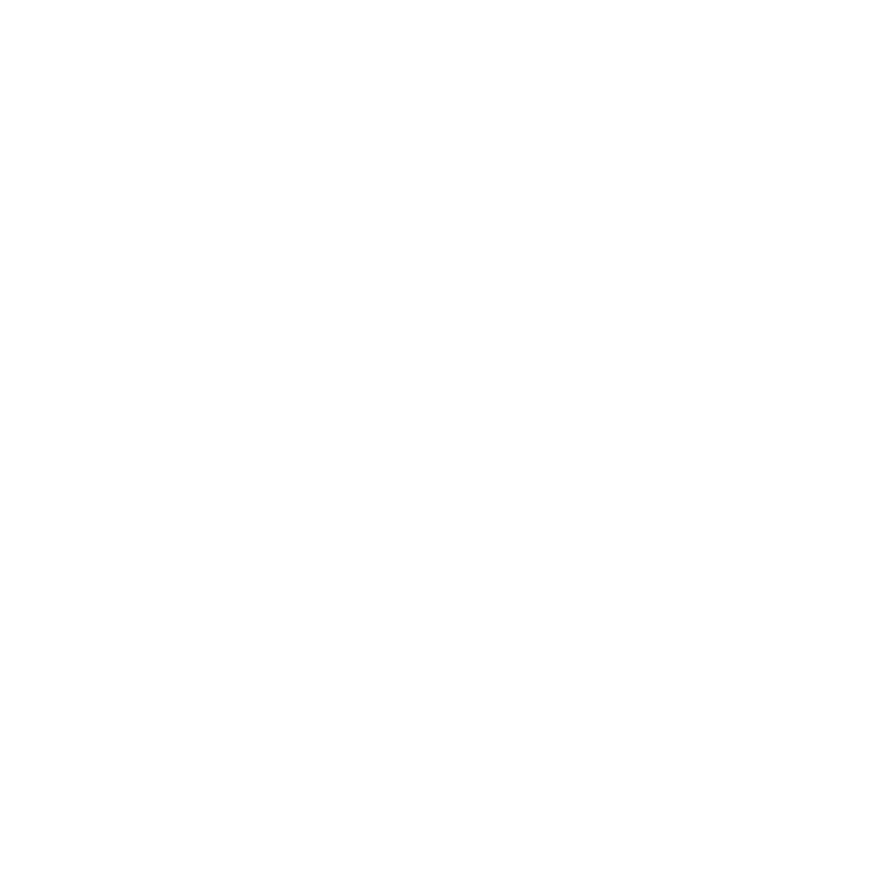

step:  0
pusher_contact_angle:  -1.373400766945016
new pusher_pt:  [ 0.04   -0.1995]
step:  1
pusher_contact_angle:  -1.3729188392714824
new pusher_pt:  [ 0.04  -0.199]
step:  2
pusher_contact_angle:  -1.372434583670784
new pusher_pt:  [ 0.04   -0.1985]
step:  3
pusher_contact_angle:  -1.3719479834634567
new pusher_pt:  [ 0.04  -0.198]
step:  4
pusher_contact_angle:  -1.3714590218125726
new pusher_pt:  [ 0.04   -0.1975]
step:  5
pusher_contact_angle:  -1.3709676817219063
new pusher_pt:  [ 0.04  -0.197]
step:  6
pusher_contact_angle:  -1.370473946034075
new pusher_pt:  [ 0.04   -0.1965]
step:  7
pusher_contact_angle:  -1.3699777974286518
new pusher_pt:  [ 0.04  -0.196]
step:  8
pusher_contact_angle:  -1.3694792184202558
new pusher_pt:  [ 0.04   -0.1955]
step:  9
pusher_contact_angle:  -1.3689781913566135
pusher inside the slider
input pusher_rel_vel:  [0.  0.1]
contact_angle:  -1.3689781913566135
norm:  [-0.2004509   0.97970375]
projection:  0.097970375042776
pusher_rel_vel:  [-0.019638

pusher velocity:  [-0.02024579  0.09571685]
contact velocity:  [-0.02027251  0.09792216]
new contact point:  [ 0.0399918  -0.18896123]
new pusher_pt:  [ 0.04   -0.1885]
step:  23
pusher_contact_angle:  -1.3618325854556637
pusher inside the slider
input pusher_rel_vel:  [4.14539881e-06 9.99999999e-02]
contact_angle:  -1.3618325854556637
norm:  [-0.2074463   0.97824641]
projection:  0.09782378076249543
pusher_rel_vel:  [-0.02029318  0.09569576]
projected point:  [-0.02621457  0.12361903  0.        ]
normal:  [-0.02039086  0.09789712  0.00060487]
slider velocity:  [-0.01994737  0.09576793  0.00059172]
pusher velocity:  [-0.02029318  0.09569576]
contact velocity:  [-0.02027252  0.09792222]
new contact point:  [ 0.03999178 -0.18846126]
new pusher_pt:  [ 0.04  -0.188]
step:  24
pusher_contact_angle:  -1.361312693244656
pusher inside the slider
input pusher_rel_vel:  [4.44125729e-06 9.99999999e-02]
contact_angle:  -1.361312693244656
norm:  [-0.20795485  0.97813843]
projection:  0.097812918925

step:  37
pusher_contact_angle:  -1.3544363889459643
pusher inside the slider
input pusher_rel_vel:  [8.28435138e-06 9.99999997e-02]
contact_angle:  -1.3544363889459643
norm:  [-0.21467586  0.97668535]
projection:  0.09766675637746111
pusher_rel_vel:  [-0.02096669  0.09538969]
projected point:  [-0.02712962  0.12342843  0.        ]
normal:  [-0.02039086  0.09789712  0.00060487]
slider velocity:  [-0.01991517  0.09561334  0.00059076]
pusher velocity:  [-0.02096669  0.09538969]
contact velocity:  [-0.02027271  0.0979231 ]
new contact point:  [ 0.03999158 -0.1814617 ]
new pusher_pt:  [ 0.04  -0.181]
step:  38
pusher_contact_angle:  -1.353898282073922
pusher inside the slider
input pusher_rel_vel:  [8.57973230e-06 9.99999996e-02]
contact_angle:  -1.353898282073922
norm:  [-0.21520139  0.97656969]
projection:  0.09765512243784082
pusher_rel_vel:  [-0.02101552  0.09536703]
projected point:  [-2.71962016e-02  1.23414567e-01  8.76906785e-19]
normal:  [-0.02039086  0.09789712  0.00060487]
slide

step:  53
pusher_contact_angle:  -1.3456657312188944
pusher inside the slider
input pusher_rel_vel:  [1.58471954e-05 9.99999987e-02]
contact_angle:  -1.3456657312188944
norm:  [-0.22323366  0.97476496]
projection:  0.09747295735376435
pusher_rel_vel:  [-0.02175925  0.09501322]
projected point:  [-0.02821177  0.1231886   0.        ]
normal:  [-0.02245515  0.09743818  0.00125208]
slider velocity:  [-0.02188942  0.09498331  0.00122053]
pusher velocity:  [-0.02175925  0.09501322]
contact velocity:  [-0.02221107  0.09749412]
new contact point:  [ 0.03999135 -0.17346224]
new pusher_pt:  [ 0.04  -0.173]
step:  54
pusher_contact_angle:  -1.3451059916734491
pusher inside the slider
input pusher_rel_vel:  [1.64574605e-05 9.99999986e-02]
contact_angle:  -1.3451059916734491
norm:  [-0.22377924  0.97463986]
projection:  0.09746030150687503
pusher_rel_vel:  [-0.02180959  0.09498869]
projected point:  [-2.82806994e-02  1.23172714e-01  8.76921243e-19]
normal:  [-0.02245515  0.09743818  0.00125208]
sli

step:  70
pusher_contact_angle:  -1.335960053136993
pusher inside the slider
input pusher_rel_vel:  [2.62105374e-05 9.99999966e-02]
contact_angle:  -1.335960053136993
norm:  [-0.23268376  0.97255245]
projection:  0.0972491429758286
pusher_rel_vel:  [-0.0226283   0.09457989]
projected point:  [-0.02940704  0.12291314  0.        ]
normal:  [-0.02245515  0.09743818  0.00125208]
slider velocity:  [-0.02183862  0.09476288  0.0012177 ]
pusher velocity:  [-0.0226283   0.09457989]
contact velocity:  [-0.02221163  0.09749651]
new contact point:  [ 0.03999111 -0.16496287]
new pusher_pt:  [ 0.04   -0.1645]
step:  71
pusher_contact_angle:  -1.3353763853086702
pusher inside the slider
input pusher_rel_vel:  [2.68193862e-05 9.99999964e-02]
contact_angle:  -1.3353763853086702
norm:  [-0.23325136  0.97241648]
projection:  0.09723538835980634
pusher_rel_vel:  [-0.02268029  0.09455329]
projected point:  [-2.94789267e-02  1.22896576e-01 -8.76955836e-19]
normal:  [-0.02245515  0.09743818  0.00125208]
slid

step:  86
pusher_contact_angle:  -1.3264520332085576
pusher inside the slider
input pusher_rel_vel:  [-9.74753172e-06  9.99999995e-02]
contact_angle:  -1.3264520332085576
norm:  [-0.24192015  0.97029616]
projection:  0.0970319738776889
pusher_rel_vel:  [-0.02347399  0.09414975]
projected point:  [-3.05766220e-02  1.22637074e-01  8.77016397e-19]
normal:  [-0.02332589  0.09667769 -0.01045594]
slider velocity:  [-0.02275688  0.09431932 -0.01020088]
pusher velocity:  [-0.02347399  0.09414975]
contact velocity:  [-0.02535501  0.09617199]
new contact point:  [ 0.0399909 -0.1569635]
new pusher_pt:  [ 0.04   -0.1565]
step:  87
pusher_contact_angle:  -1.325846227856505
pusher inside the slider
input pusher_rel_vel:  [-1.48479692e-05  9.99999989e-02]
contact_angle:  -1.325846227856505
norm:  [-0.24250791  0.97014943]
projection:  0.0970185424389171
pusher_rel_vel:  [-0.02352776  0.09412248]
projected point:  [-0.03065106  0.12261911  0.        ]
normal:  [-0.02332589  0.09667769 -0.01045594]
sli

step:  102
pusher_contact_angle:  -1.3165901841778946
pusher inside the slider
input pusher_rel_vel:  [-3.17565275e-05  9.99999950e-02]
contact_angle:  -1.3165901841778946
norm:  [-0.25147714  0.96786324]
projection:  0.0967943049236687
pusher_rel_vel:  [-0.02434156  0.09368365]
projected point:  [-0.03178458  0.12232973  0.        ]
normal:  [-0.02564267  0.09623104  0.00905764]
slider velocity:  [-0.02492193  0.09352626  0.00880305]
pusher velocity:  [-0.02434156  0.09368365]
contact velocity:  [-0.02388922  0.09668604]
new contact point:  [ 0.0399907  -0.14896418]
new pusher_pt:  [ 0.04   -0.1485]
step:  103
pusher_contact_angle:  -1.3159607548233778
pusher inside the slider
input pusher_rel_vel:  [-2.73550004e-05  9.99999963e-02]
contact_angle:  -1.3159607548233778
norm:  [-0.25208629  0.96770476]
projection:  0.09677736808228025
pusher_rel_vel:  [-0.02439625  0.09365192]
projected point:  [-0.03186146  0.12230924  0.        ]
normal:  [-0.02564267  0.09623104  0.00905764]
slider v

step:  118
pusher_contact_angle:  -1.3063207656590237
pusher inside the slider
input pusher_rel_vel:  [4.30379198e-05 9.99999907e-02]
contact_angle:  -1.3063207656590237
norm:  [-0.2614031   0.96522972]
projection:  0.09651171317069929
pusher_rel_vel:  [-0.02522846  0.09315597]
projected point:  [-0.0330387   0.12199526  0.        ]
normal:  [-0.02565297  0.09612735  0.01007266]
slider velocity:  [-0.02487751  0.09322152  0.00976817]
pusher velocity:  [-0.02522846  0.09315597]
contact velocity:  [-0.02370871  0.09665479]
new contact point:  [ 0.03999048 -0.14096492]
new pusher_pt:  [ 0.04   -0.1405]
step:  119
pusher_contact_angle:  -1.3056646467432917
pusher inside the slider
input pusher_rel_vel:  [4.79220045e-05 9.99999885e-02]
contact_angle:  -1.3056646467432917
norm:  [-0.26203635  0.965058  ]
projection:  0.09649323204036342
pusher_rel_vel:  [-0.02528473  0.09312157]
projected point:  [-0.03311883  0.12197388  0.        ]
normal:  [-0.02565297  0.09612735  0.01007266]
slider velo

step:  135
pusher_contact_angle:  -1.294933541157986
pusher inside the slider
input pusher_rel_vel:  [0.00011445 0.09999993]
contact_angle:  -1.294933541157986
norm:  [-0.2723772   0.96219055]
projection:  0.09618781971403997
pusher_rel_vel:  [-0.02619937  0.09255101]
projected point:  [-0.0344247   0.12160755  0.        ]
normal:  [-0.02802139  0.09574413  0.0069183 ]
slider velocity:  [-0.02701819  0.09231638  0.00667062]
pusher velocity:  [-0.02619937  0.09255101]
contact velocity:  [-0.02669048  0.09612253]
new contact point:  [ 0.03999027 -0.13246578]
new pusher_pt:  [ 0.04  -0.132]
step:  136
pusher_contact_angle:  -1.294248245476369
pusher inside the slider
input pusher_rel_vel:  [0.00011778 0.09999993]
contact_angle:  -1.294248245476369
norm:  [-0.27303652  0.96200367]
projection:  0.09616814139944516
pusher_rel_vel:  [-0.02625741  0.0925141 ]
projected point:  [-0.03450783  0.12158322  0.        ]
normal:  [-0.02802139  0.09574413  0.0069183 ]
slider velocity:  [-0.02701239  0

step:  151
pusher_contact_angle:  -1.2837588804103708
pusher inside the slider
input pusher_rel_vel:  [0.00016772 0.09999986]
contact_angle:  -1.2837588804103708
norm:  [-0.28311213  0.95908682]
projection:  0.09586106240830637
pusher_rel_vel:  [-0.02713943  0.09193908]
projected point:  [-0.03578014  0.12121086  0.        ]
normal:  [-0.02802139  0.09574413  0.0069183 ]
slider velocity:  [-0.02692204  0.09198783  0.00664688]
pusher velocity:  [-0.02713943  0.09193908]
contact velocity:  [-0.026695    0.09613809]
new contact point:  [ 0.03999009 -0.12446665]
new pusher_pt:  [ 0.04  -0.124]
step:  152
pusher_contact_angle:  -1.2830454201661252
pusher inside the slider
input pusher_rel_vel:  [0.00017105 0.09999985]
contact_angle:  -1.2830454201661252
norm:  [-0.28379632  0.95888458]
projection:  0.09583977577193972
pusher_rel_vel:  [-0.02719898  0.09189928]
projected point:  [-0.03586668  0.12118553  0.        ]
normal:  [-0.02802139  0.09574413  0.0069183 ]
slider velocity:  [-0.0269157

step:  165
pusher_contact_angle:  -1.2736089419149064
pusher inside the slider
input pusher_rel_vel:  [0.00018521 0.09999983]
contact_angle:  -1.2736089419149064
norm:  [-0.29283205  0.95616389]
projection:  0.09556198856402985
pusher_rel_vel:  [-0.02798361  0.09137292]
projected point:  [-3.70110068e-02  1.20849438e-01 -8.77005954e-19]
normal:  [-0.02822357  0.0959324  -0.00063699]
slider velocity:  [-0.02697197  0.0916782  -0.00060874]
pusher velocity:  [-0.02798361  0.09137292]
contact velocity:  [-0.02834531  0.09589486]
new contact point:  [ 0.03998996 -0.11746744]
new pusher_pt:  [ 0.04  -0.117]
step:  166
pusher_contact_angle:  -1.2728708048317652
pusher inside the slider
input pusher_rel_vel:  [0.00018491 0.09999983]
contact_angle:  -1.2728708048317652
norm:  [-0.29353775  0.95594748]
projection:  0.09554030671264833
pusher_rel_vel:  [-0.02804469  0.09133152]
projected point:  [-0.03710051  0.1208231   0.        ]
normal:  [-0.02822357  0.0959324  -0.00063699]
slider velocity: 

step:  181
pusher_contact_angle:  -1.261588036612735
pusher inside the slider
input pusher_rel_vel:  [0.00015846 0.09999987]
contact_angle:  -1.261588036612735
norm:  [-0.30430457  0.95257479]
projection:  0.09520914012296582
pusher_rel_vel:  [-0.02897258  0.09069383]
projected point:  [-0.03846249  0.12040041  0.        ]
normal:  [-0.03046279  0.09507446 -0.00573284]
slider velocity:  [-0.02904946  0.09066346 -0.00546686]
pusher velocity:  [-0.02897258  0.09069383]
contact velocity:  [-0.03155442  0.09472383]
new contact point:  [ 0.03998986 -0.10946842]
new pusher_pt:  [ 0.04  -0.109]
step:  182
pusher_contact_angle:  -1.2608218666397784
pusher inside the slider
input pusher_rel_vel:  [0.00015572 0.09999988]
contact_angle:  -1.2608218666397784
norm:  [-0.30503431  0.95234136]
projection:  0.09518651953843354
pusher_rel_vel:  [-0.02903515  0.09065006]
projected point:  [-3.85547068e-02  1.20370857e-01 -8.77039099e-19]
normal:  [-0.03046279  0.09507446 -0.00573284]
slider velocity:  [

projection:  0.09481801338503892
pusher_rel_vel:  [-0.02997846  0.08995414]
projected point:  [-3.99629756e-02  1.19913936e-01 -8.77060586e-19]
normal:  [-0.03114071  0.09485438  0.00573606]
slider velocity:  [-0.02957166  0.09007508  0.00544705]
pusher velocity:  [-0.02997846  0.08995414]
contact velocity:  [-0.03005294  0.09521889]
new contact point:  [ 0.03998977 -0.10146949]
new pusher_pt:  [ 0.04  -0.101]
step:  198
pusher_contact_angle:  -1.2483121897119296
pusher inside the slider
input pusher_rel_vel:  [0.00016772 0.09999986]
contact_angle:  -1.2483121897119296
norm:  [-0.31692362  0.94845106]
projection:  0.09479181948507408
pusher_rel_vel:  [-0.03004177  0.0899054 ]
projected point:  [-0.04005823  0.11988147  0.        ]
normal:  [-3.25151465e-02  9.45661895e-02 -3.24814807e-05]
slider velocity:  [-3.08216865e-02  8.96409753e-02 -3.07897741e-05]
pusher velocity:  [-0.03004177  0.0899054 ]
contact velocity:  [-0.0325213   0.09456412]
new contact point:  [ 0.03998977 -0.1009695

step:  214
pusher_contact_angle:  -1.2353164773847896
pusher inside the slider
input pusher_rel_vel:  [0.00015271 0.09999988]
contact_angle:  -1.2353164773847896
norm:  [-0.32922231  0.94425244]
projection:  0.0943748582635913
pusher_rel_vel:  [-0.03107031  0.08911369]
projected point:  [-0.04161049  0.11934431  0.        ]
normal:  [-0.03271305  0.09447085 -0.00226161]
slider velocity:  [-0.03088099  0.0891801  -0.00213495]
pusher velocity:  [-0.03107031  0.08911369]
contact velocity:  [-0.03313993  0.09432128]
new contact point:  [ 0.03998972 -0.09297067]
new pusher_pt:  [ 0.04   -0.0925]
step:  215
pusher_contact_angle:  -1.234488015408797
pusher inside the slider
input pusher_rel_vel:  [0.00015164 0.09999989]
contact_angle:  -1.234488015408797
norm:  [-0.33000447  0.94397937]
projection:  0.09434778543710305
pusher_rel_vel:  [-0.03113519  0.08906236]
projected point:  [-4.17094389e-02  1.19310050e-01  8.77010455e-19]
normal:  [-0.03271305  0.09447085 -0.00226161]
slider velocity:  

step:  231
pusher_contact_angle:  -1.2209635568916521
pusher inside the slider
input pusher_rel_vel:  [0.0001667  0.09999986]
contact_angle:  -1.2209635568916521
norm:  [-0.34274071  0.93943004]
projection:  0.09388574005479122
pusher_rel_vel:  [-0.03217847  0.08819908]
projected point:  [-0.04332114  0.11874043  0.        ]
normal:  [-0.03379682  0.09378822  0.00784503]
slider velocity:  [-0.03182172  0.08830722  0.00738657]
pusher velocity:  [-0.03217847  0.08819908]
contact velocity:  [-0.03232374  0.09432844]
new contact point:  [ 0.03998972 -0.08447198]
new pusher_pt:  [ 0.04  -0.084]
step:  232
pusher_contact_angle:  -1.2201008142031613
pusher inside the slider
input pusher_rel_vel:  [0.00017039 0.09999985]
contact_angle:  -1.2201008142031613
norm:  [-0.34355107  0.939134  ]
projection:  0.09385472567332614
pusher_rel_vel:  [-0.03224389  0.08814216]
projected point:  [-4.34232018e-02  1.18702017e-01 -1.75408559e-18]
normal:  [-0.03657234  0.09304009 -0.00245068]
slider velocity: 

slider velocity:  [-0.03419999  0.08700481 -0.00229171]
pusher velocity:  [-0.03304019  0.08745878]
contact velocity:  [-0.03703058  0.09286615]
new contact point:  [ 0.03998976 -0.07797301]
new pusher_pt:  [ 0.04   -0.0775]
step:  245
pusher_contact_angle:  -1.2087014163865661
pusher inside the slider
input pusher_rel_vel:  [0.00015546 0.09999988]
contact_angle:  -1.2087014163865661
norm:  [-0.35423408  0.93515679]
projection:  0.0934604947944412
pusher_rel_vel:  [-0.03310689  0.08740022]
projected point:  [-0.04476423  0.11817488  0.        ]
normal:  [-0.03657234  0.09304009 -0.00245068]
slider velocity:  [-0.03418873  0.08697617 -0.00229096]
pusher velocity:  [-0.03310689  0.08740022]
contact velocity:  [-0.03703043  0.09286575]
new contact point:  [ 0.03998976 -0.07747309]
new pusher_pt:  [ 0.04  -0.077]
step:  246
pusher_contact_angle:  -1.2078102690821462
pusher inside the slider
input pusher_rel_vel:  [0.00015432 0.09999988]
contact_angle:  -1.2078102690821462
norm:  [-0.355067

step:  259
pusher_contact_angle:  -1.1960364547877465
pusher inside the slider
input pusher_rel_vel:  [0.00013946 0.0999999 ]
contact_angle:  -1.1960364547877465
norm:  [-0.36604908  0.93059555]
projection:  0.09300841381825793
pusher_rel_vel:  [-0.03404564  0.08655322]
projected point:  [-0.0462537  0.1175894  0.       ]
normal:  [-0.03657234  0.09304009 -0.00245068]
slider velocity:  [-0.03402544  0.08656076 -0.00228002]
pusher velocity:  [-0.03404564  0.08655322]
contact velocity:  [-0.03702821  0.09286004]
new contact point:  [ 0.03998985 -0.07047429]
new pusher_pt:  [ 0.04 -0.07]
step:  260
pusher_contact_angle:  -1.1951161007381805
pusher inside the slider
input pusher_rel_vel:  [0.00013832 0.0999999 ]
contact_angle:  -1.1951161007381805
norm:  [-0.3669054   0.93025826]
projection:  0.09297498528999273
pusher_rel_vel:  [-0.03411302  0.08649075]
projected point:  [-0.04636194  0.11754685  0.        ]
normal:  [-0.03657234  0.09304009 -0.00245068]
slider velocity:  [-0.03401336  0.

step:  274
pusher_contact_angle:  -1.1820069151108576
pusher inside the slider
input pusher_rel_vel:  [0.00012241 0.09999993]
contact_angle:  -1.1820069151108576
norm:  [-0.37906845  0.92536863]
projection:  0.09249039357439799
pusher_rel_vel:  [-0.03506019  0.08558771]
projected point:  [-4.79036933e-02  1.16940819e-01 -1.75376581e-18]
normal:  [-0.03657234  0.09304009 -0.00245068]
slider velocity:  [-0.03383823  0.0860845  -0.00226747]
pusher velocity:  [-0.03506019  0.08558771]
contact velocity:  [-0.03702567  0.09285374]
new contact point:  [ 0.03998999 -0.06297565]
new pusher_pt:  [ 0.04   -0.0625]
step:  275
pusher_contact_angle:  -1.181054360742573
pusher inside the slider
input pusher_rel_vel:  [0.00012127 0.09999993]
contact_angle:  -1.181054360742573
norm:  [-0.37994974  0.92500713]
projection:  0.09245456745815042
pusher_rel_vel:  [-0.03512809  0.08552113]
projected point:  [-0.04801574  0.11689678  0.        ]
normal:  [-0.03657234  0.09304009 -0.00245068]
slider velocity: 

step:  288
pusher_contact_angle:  -1.168471070325349
pusher inside the slider
input pusher_rel_vel:  [0.00010799 0.09999994]
contact_angle:  -1.168471070325349
norm:  [-0.39155899  0.92015301]
projection:  0.0919729642398581
pusher_rel_vel:  [-0.03601284  0.0846292 ]
projected point:  [-0.04949068  0.11630177  0.        ]
normal:  [-0.0408951   0.09116735 -0.00401299]
slider velocity:  [-0.03763603  0.0839019  -0.00369318]
pusher velocity:  [-0.03601284  0.0846292 ]
contact velocity:  [-0.04163328  0.09085229]
new contact point:  [ 0.03999018 -0.05597699]
new pusher_pt:  [ 0.04   -0.0555]
step:  289
pusher_contact_angle:  -1.167487591463166
pusher inside the slider
input pusher_rel_vel:  [0.00010614 0.09999994]
contact_angle:  -1.167487591463166
norm:  [-0.39246375  0.91976747]
projection:  0.0919350396060123
pusher_rel_vel:  [-0.03608117  0.08455886]
projected point:  [-0.04960412  0.11625088  0.        ]
normal:  [-0.0408951   0.09116735 -0.00401299]
slider velocity:  [-0.0376208   0

step:  304
pusher_contact_angle:  -1.1524661802774279
pusher inside the slider
input pusher_rel_vel:  [8.24115601e-05 9.99999660e-02]
contact_angle:  -1.1524661802774279
norm:  [-0.40623516  0.91376857]
projection:  0.09134334721411913
pusher_rel_vel:  [-0.03710688  0.08346668]
projected point:  [-5.13356021e-02  1.15472180e-01  1.75372460e-18]
normal:  [-0.04141914  0.09101869  0.0002283 ]
slider velocity:  [-0.03783386  0.08314003  0.00020854]
pusher velocity:  [-0.03710688  0.08346668]
contact velocity:  [-0.04137743  0.09103728]
new contact point:  [ 0.03999047 -0.04797861]
new pusher_pt:  [ 0.04   -0.0475]
step:  305
pusher_contact_angle:  -1.1514464990457012
pusher inside the slider
input pusher_rel_vel:  [8.25158305e-05 9.99999660e-02]
contact_angle:  -1.1514464990457012
norm:  [-0.4071667   0.91335386]
projection:  0.09130175739024714
pusher_rel_vel:  [-0.03717504  0.08339081]
projected point:  [-0.05145289  0.11541881  0.        ]
normal:  [-0.04141914  0.09101869  0.0002283 ]

step:  320
pusher_contact_angle:  -1.1358687028289784
pusher inside the slider
input pusher_rel_vel:  [8.40740591e-05 9.99999647e-02]
contact_angle:  -1.1358687028289784
norm:  [-0.42134476  0.90690054]
projection:  0.09065459777721621
pusher_rel_vel:  [-0.03819684  0.0822147 ]
projected point:  [-0.05324461  0.11460346  0.        ]
normal:  [-0.04141914  0.09101869  0.0002283 ]
slider velocity:  [-0.0375483   0.08251251  0.00020697]
pusher velocity:  [-0.03819684  0.0822147 ]
contact velocity:  [-0.04137775  0.09103797]
new contact point:  [ 0.03999084 -0.03998033]
new pusher_pt:  [ 0.04   -0.0395]
step:  321
pusher_contact_angle:  -1.1348111511955792
pusher inside the slider
input pusher_rel_vel:  [8.41775425e-05 9.99999646e-02]
contact_angle:  -1.1348111511955792
norm:  [-0.42230362  0.90645444]
projection:  0.09060986330689919
pusher_rel_vel:  [-0.03826487  0.08213371]
projected point:  [-5.33662568e-02  1.14548106e-01  1.75372776e-18]
normal:  [-0.04141914  0.09101869  0.0002283 ]

step:  336
pusher_contact_angle:  -1.118659719336816
pusher inside the slider
input pusher_rel_vel:  [6.86795942e-05 9.99999764e-02]
contact_angle:  -1.118659719336816
norm:  [-0.43688844  0.8995157 ]
projection:  0.0899215431789901
pusher_rel_vel:  [-0.03928568  0.08088584]
projected point:  [-5.52036617e-02  1.13659588e-01 -1.75354766e-18]
normal:  [-0.04448567  0.08951867 -0.00272646]
slider velocity:  [-0.04001465  0.08052163 -0.00245244]
pusher velocity:  [-0.03928568  0.08088584]
contact velocity:  [-0.044976   0.0892801]
new contact point:  [ 0.03999132 -0.03198216]
new pusher_pt:  [ 0.04   -0.0315]
step:  337
pusher_contact_angle:  -1.1175636254891204
pusher inside the slider
input pusher_rel_vel:  [6.74533742e-05 9.99999773e-02]
contact_angle:  -1.1175636254891204
norm:  [-0.43787413  0.89903629]
projection:  0.08987407207523575
pusher_rel_vel:  [-0.03935353  0.08080005]
projected point:  [-5.53276938e-02  1.13597951e-01 -1.75353129e-18]
normal:  [-0.04448567  0.08951867 -0.00

step:  354
pusher_contact_angle:  -1.0985517532793414
pusher inside the slider
input pusher_rel_vel:  [6.30964452e-05 9.99999801e-02]
contact_angle:  -1.0985517532793414
norm:  [-0.45488633  0.89054951]
projection:  0.08902623122013803
pusher_rel_vel:  [-0.04049682  0.07928227]
projected point:  [-0.05747679  0.11252464  0.        ]
normal:  [-0.04489075  0.08932231  0.002519  ]
slider velocity:  [-0.03997527  0.07954164  0.00224318]
pusher velocity:  [-0.04049682  0.07928227]
contact velocity:  [-0.04444223  0.08955177]
new contact point:  [ 0.03999199 -0.02298434]
new pusher_pt:  [ 0.04   -0.0225]
step:  355
pusher_contact_angle:  -1.0974106701759323
pusher inside the slider
input pusher_rel_vel:  [6.42180331e-05 9.99999794e-02]
contact_angle:  -1.0974106701759323
norm:  [-0.45590223  0.89002986]
projection:  0.0889736908837036
pusher_rel_vel:  [-0.0405633   0.07918924]
projected point:  [-0.05760562  0.1124599   0.        ]
normal:  [-0.04489075  0.08932231  0.002519  ]
slider veloc

step:  369
pusher_contact_angle:  -1.0811637657194806
pusher inside the slider
input pusher_rel_vel:  [8.24925153e-05 9.99999660e-02]
contact_angle:  -1.0811637657194806
norm:  [-0.47030165  0.88250573]
projection:  0.08821174613774457
pusher_rel_vel:  [-0.04148613  0.07784737]
projected point:  [-5.94280959e-02  1.11514885e-01 -1.75362026e-18]
normal:  [-0.04806868  0.0875974   0.00401212]
slider velocity:  [-0.04243892  0.07733807  0.00354223]
pusher velocity:  [-0.04148613  0.07784737]
contact velocity:  [-0.04736085  0.08797537]
new contact point:  [ 0.03999266 -0.01548626]
new pusher_pt:  [ 0.04  -0.015]
step:  370
pusher_contact_angle:  -1.0799836442936586
pusher inside the slider
input pusher_rel_vel:  [8.42636279e-05 9.99999645e-02]
contact_angle:  -1.0799836442936586
norm:  [-0.47134279  0.8819501 ]
projection:  0.08815526142163128
pusher_rel_vel:  [-0.04155135  0.07774854]
projected point:  [-0.05955884  0.11144314  0.        ]
normal:  [-0.04806868  0.0875974   0.00401212]
s

pusher_rel_vel:  [-0.04232575  0.07653149]
projected point:  [-6.11495354e-02  1.10567806e-01  1.75346853e-18]
normal:  [-0.04823144  0.08743885  0.005308  ]
slider velocity:  [-0.04223742  0.07657229  0.00464834]
pusher velocity:  [-0.04232575  0.07653149]
contact velocity:  [-0.04730301  0.08795364]
new contact point:  [ 0.03999335 -0.00898801]
new pusher_pt:  [ 0.04   -0.0085]
step:  383
pusher_contact_angle:  -1.0643994903071845
pusher inside the slider
input pusher_rel_vel:  [0.00011117 0.09999994]
contact_angle:  -1.0643994903071845
norm:  [-0.48502944  0.87449782]
projection:  0.08739580784902866
pusher_rel_vel:  [-0.04238954  0.07642744]
projected point:  [-0.06128395  0.11049366  0.        ]
normal:  [-0.04823144  0.08743885  0.005308  ]
slider velocity:  [-0.04220784  0.07651866  0.00464509]
pusher velocity:  [-0.04238954  0.07642744]
contact velocity:  [-0.04730365  0.08795479]
new contact point:  [ 0.03999341 -0.00848814]
new pusher_pt:  [ 0.04  -0.008]
step:  384
pusher_co

step:  399
pusher_contact_angle:  -1.0445894555585107
pusher inside the slider
input pusher_rel_vel:  [0.00014767 0.09999989]
contact_angle:  -1.0445894555585107
norm:  [-0.50225697  0.86471841]
projection:  0.08639758032676619
pusher_rel_vel:  [-0.04339379  0.07470958]
projected point:  [-6.34647038e-02  1.09264979e-01 -1.75358380e-18]
normal:  [-0.04925033  0.08687444  0.00521884]
slider velocity:  [-0.04260151  0.07514635  0.0045143 ]
pusher velocity:  [-0.04339379  0.07470958]
contact velocity:  [-0.04834854  0.08740002]
new contact point:  [ 0.0399944 -0.0004904]
new pusher_pt:  [4.00000000e-02 1.63064007e-16]
step:  400
pusher_contact_angle:  -1.0433279207430475
pusher inside the slider
input pusher_rel_vel:  [0.00014992 0.09999989]
contact_angle:  -1.0433279207430475
norm:  [-0.50334745  0.86408411]
projection:  0.08633285008129624
pusher_rel_vel:  [-0.04345542  0.07459884]
projected point:  [-6.36033857e-02  1.09186359e-01 -3.50721672e-18]
normal:  [-0.04925033  0.08687444  0.0

step:  413
pusher_contact_angle:  -1.026674221333142
pusher inside the slider
input pusher_rel_vel:  [0.00017001 0.09999986]
contact_angle:  -1.026674221333142
norm:  [-0.51766718  0.85558208]
projection:  0.08547007543254805
pusher_rel_vel:  [-0.04424505  0.07312666]
projected point:  [-0.06543073  0.1081416   0.        ]
normal:  [-0.05283147  0.08461213 -0.00704437]
slider velocity:  [-0.04525516  0.07247829 -0.00603417]
pusher velocity:  [-0.04424505  0.07312666]
contact velocity:  [-0.05403564  0.08388075]
new contact point:  [0.03999541 0.00650755]
new pusher_pt:  [0.04  0.007]
step:  414
pusher_contact_angle:  -1.0253737612613258
pusher inside the slider
input pusher_rel_vel:  [0.00016699 0.09999986]
contact_angle:  -1.0253737612613258
norm:  [-0.51877939  0.85490815]
projection:  0.08540406310882777
pusher_rel_vel:  [-0.04430587  0.07301263]
projected point:  [-0.06557017  0.10805454  0.        ]
normal:  [-0.05283147  0.08461213 -0.00704437]
slider velocity:  [-0.04522101  0.0

step:  430
pusher_contact_angle:  -1.0041931758620348
pusher inside the slider
input pusher_rel_vel:  [0.00012809 0.09999992]
contact_angle:  -1.0041931758620348
norm:  [-0.53676913  0.84372916]
projection:  0.08430409447984188
pusher_rel_vel:  [-0.04525184  0.07112982]
projected point:  [-0.06783998  0.10663536  0.        ]
normal:  [-0.05297432  0.08467307 -0.00491867]
slider velocity:  [-0.04471536  0.07147212 -0.00415182]
pusher velocity:  [-0.04525184  0.07112982]
contact velocity:  [-0.05380365  0.08414397]
new contact point:  [0.03999685 0.01500494]
new pusher_pt:  [0.04   0.0155]
step:  431
pusher_contact_angle:  -1.0028457959989074
pusher inside the slider
input pusher_rel_vel:  [0.00012601 0.09999992]
contact_angle:  -1.0028457959989074
norm:  [-0.53790547  0.84300517]
projection:  0.08423266810080444
pusher_rel_vel:  [-0.04530921  0.07100857]
projected point:  [-0.06798435  0.10654503  0.        ]
normal:  [-0.05297432  0.08467307 -0.00491867]
slider velocity:  [-0.04467806 

step:  448
pusher_contact_angle:  -0.9794993552483828
pusher inside the slider
input pusher_rel_vel:  [0.00013866 0.0999999 ]
contact_angle:  -0.9794993552483828
norm:  [-0.55743826  0.8302184 ]
projection:  0.08294446517340008
pusher_rel_vel:  [-0.04623642  0.06886202]
projected point:  [-7.04478799e-02  1.04921262e-01 -1.75384576e-18]
normal:  [-0.05599908  0.08263441 -0.0059714 ]
slider velocity:  [-0.04652622  0.0686559  -0.00496128]
pusher velocity:  [-0.04623642  0.06886202]
contact velocity:  [-0.05698967  0.0819673 ]
new contact point:  [0.03999862 0.02400205]
new pusher_pt:  [0.04   0.0245]
step:  449
pusher_contact_angle:  -0.9781000506009309
pusher inside the slider
input pusher_rel_vel:  [0.00013618 0.09999991]
contact_angle:  -0.9781000506009309
norm:  [-0.55859944  0.82943756]
projection:  0.08286760889749423
pusher_rel_vel:  [-0.0462898   0.06873351]
projected point:  [-0.07059427  0.10482206  0.        ]
normal:  [-0.05599908  0.08263441 -0.0059714 ]
slider velocity:  [

step:  464
pusher_contact_angle:  -0.9567651088195606
pusher inside the slider
input pusher_rel_vel:  [0.00011134 0.09999994]
contact_angle:  -0.9567651088195606
norm:  [-0.57616698  0.81733201]
projection:  0.08166899748146067
pusher_rel_vel:  [-0.04705498  0.06675069]
projected point:  [-0.07281273  0.10328981  0.        ]
normal:  [-0.05744361  0.08181509 -0.00255404]
slider velocity:  [-0.04692904  0.06683952 -0.00208654]
pusher velocity:  [-0.04705498  0.06675069]
contact velocity:  [-0.05786078  0.08152031]
new contact point:  [0.04000044 0.03199938]
new pusher_pt:  [0.04   0.0325]
step:  465
pusher_contact_angle:  -0.9553194823563743
pusher inside the slider
input pusher_rel_vel:  [0.0001103  0.09999994]
contact_angle:  -0.9553194823563743
norm:  [-0.57734793  0.81649823]
projection:  0.08158609171691909
pusher_rel_vel:  [-0.04710356  0.0666149 ]
projected point:  [-7.29622496e-02  1.03184830e-01 -1.75380315e-18]
normal:  [-0.05744361  0.08181509 -0.00255404]
slider velocity:  [

step:  480
pusher_contact_angle:  -0.933280648103276
pusher inside the slider
input pusher_rel_vel:  [9.75798202e-05 9.99999524e-02]
contact_angle:  -0.933280648103276
norm:  [-0.59520094  0.80357691]
projection:  0.08029957279315746
pusher_rel_vel:  [-0.04779438  0.06452688]
projected point:  [-0.07522369  0.10155902  0.        ]
normal:  [-0.06031721  0.07966166 -0.00398166]
slider velocity:  [-0.04846766  0.06401182 -0.00319945]
pusher velocity:  [-0.04779438  0.06452688]
contact velocity:  [-0.06095667  0.07918706]
new contact point:  [0.04000251 0.03999662]
new pusher_pt:  [0.04   0.0405]
step:  481
pusher_contact_angle:  -0.931787691124198
pusher inside the slider
input pusher_rel_vel:  [9.59800979e-05 9.99999539e-02]
contact_angle:  -0.931787691124198
norm:  [-0.59639998  0.8026874 ]
projection:  0.0802114606885517
pusher_rel_vel:  [-0.04783811  0.06438473]
projected point:  [-0.07537413  0.10144512  0.        ]
normal:  [-0.06031721  0.07966166 -0.00398166]
slider velocity:  [-

norm:  [-0.61207973  0.79079606]
projection:  0.0790390513534368
pusher_rel_vel:  [-0.0483782   0.06250377]
projected point:  [-0.07735415  0.09994018  0.        ]
normal:  [-0.06046866  0.07815842 -0.01532328]
slider velocity:  [-0.04834311  0.0624856  -0.01225056]
pusher velocity:  [-0.0483782   0.06250377]
contact velocity:  [-0.06289093  0.076281  ]
new contact point:  [0.04000454 0.04699415]
new pusher_pt:  [0.04   0.0475]
step:  495
pusher_contact_angle:  -0.9105740153929888
pusher inside the slider
input pusher_rel_vel:  [6.01034402e-05 9.99999819e-02]
contact_angle:  -0.9105740153929888
norm:  [-0.61329246  0.78985591]
projection:  0.07894871565773756
pusher_rel_vel:  [-0.04841865  0.06235811]
projected point:  [-0.07750727  0.09982117  0.        ]
normal:  [-0.06075379  0.0765562  -0.02116896]
slider velocity:  [-0.04900941  0.06175704 -0.01707677]
pusher velocity:  [-0.04841865  0.06235811]
contact velocity:  [-0.06409631  0.07395764]
new contact point:  [0.04000469 0.0474939

step:  512
pusher_contact_angle:  -0.8840447125577291
pusher inside the slider
input pusher_rel_vel:  [-5.85976801e-05  9.99999828e-02]
contact_angle:  -0.8840447125577291
norm:  [-0.63402852  0.77330966]
projection:  0.07736810538272004
pusher_rel_vel:  [-0.04905359  0.0598295 ]
projected point:  [-0.08012446  0.09772592  0.        ]
normal:  [-0.06200825  0.07700324 -0.01501597]
slider velocity:  [-0.04851452  0.06024643 -0.01174832]
pusher velocity:  [-0.04905359  0.0598295 ]
contact velocity:  [-0.06433176  0.07510049]
new contact point:  [0.04000747 0.05599087]
new pusher_pt:  [0.04   0.0565]
step:  513
pusher_contact_angle:  -0.8824577295345506
pusher inside the slider
input pusher_rel_vel:  [-6.44718378e-05  9.99999792e-02]
contact_angle:  -0.8824577295345506
norm:  [-0.63525495  0.77230249]
projection:  0.07727118947448508
pusher_rel_vel:  [-0.04908691  0.05967673]
projected point:  [-8.02806761e-02  9.76001305e-02 -1.75381267e-18]
normal:  [-0.06200825  0.07700324 -0.01501597]

step:  527
pusher_contact_angle:  -0.8599233740993981
pusher inside the slider
input pusher_rel_vel:  [-8.44195368e-05  9.99999644e-02]
contact_angle:  -0.8599233740993981
norm:  [-0.65249554  0.75779257]
projection:  0.07583431307451916
pusher_rel_vel:  [-0.04948155  0.05746668]
projected point:  [-0.08246559  0.09577355  0.        ]
normal:  [-0.06467303  0.07580621  0.00841535]
slider velocity:  [-0.04920883  0.05767991  0.00640312]
pusher velocity:  [-0.04948155  0.05746668]
contact velocity:  [-0.06339668  0.07690333]
new contact point:  [0.04001021 0.06348812]
new pusher_pt:  [0.04  0.064]
step:  528
pusher_contact_angle:  -0.8582904497507773
pusher inside the slider
input pusher_rel_vel:  [-8.12179757e-05  9.99999670e-02]
contact_angle:  -0.8582904497507773
norm:  [-0.65373208  0.75672608]
projection:  0.07572567797645913
pusher_rel_vel:  [-0.04950431  0.0573036 ]
projected point:  [-8.26226014e-02  9.56396036e-02 -1.75395848e-18]
normal:  [-0.06467303  0.07580621  0.00841535]
s

projection:  0.07429856538593753
pusher_rel_vel:  [-0.04976949  0.05516588]
projected point:  [-0.08466004  0.09383953  0.        ]
normal:  [-0.06754956  0.07267329  0.01247599]
slider velocity:  [-0.05058741  0.05442454  0.00934319]
pusher velocity:  [-0.04976949  0.05516588]
contact velocity:  [-0.06569566  0.07434334]
new contact point:  [0.04001304 0.07048552]
new pusher_pt:  [0.04  0.071]
step:  542
pusher_contact_angle:  -0.8351021008512194
pusher inside the slider
input pusher_rel_vel:  [-6.94741566e-05  9.99999759e-02]
contact_angle:  -0.8351021008512194
norm:  [-0.67110199  0.74136504]
projection:  0.07418310992090837
pusher_rel_vel:  [-0.04978443  0.05499676]
projected point:  [-8.48152617e-02  9.36952509e-02  1.75390361e-18]
normal:  [-0.06754956  0.07267329  0.01247599]
slider velocity:  [-0.05050661  0.05433761  0.00932826]
pusher velocity:  [-0.04978443  0.05499676]
contact velocity:  [-0.06569854  0.07434654]
new contact point:  [0.04001326 0.07098533]
new pusher_pt:  [

step:  557
pusher_contact_angle:  -0.8095682193419839
pusher inside the slider
input pusher_rel_vel:  [-4.20255330e-06  9.99999999e-02]
contact_angle:  -0.8095682193419839
norm:  [-0.6898111   0.72398939]
projection:  0.07240183838161571
pusher_rel_vel:  [-0.04994359  0.05241816]
projected point:  [-0.08717358  0.0914928   0.        ]
normal:  [-0.06837056  0.07223752  0.01035408]
slider velocity:  [-0.04975486  0.05256894  0.00753491]
pusher velocity:  [-0.04994359  0.05241816]
contact velocity:  [-0.06687125  0.07366593]
new contact point:  [0.04001664 0.07848253]
new pusher_pt:  [0.04  0.079]
step:  558
pusher_contact_angle:  -0.8078403608356277
pusher inside the slider
input pusher_rel_vel:  [-4.35099468e-07  1.00000000e-01]
contact_angle:  -0.8078403608356277
norm:  [-0.69106102  0.72279642]
projection:  0.0722799425452073
pusher_rel_vel:  [-0.04994985  0.05224368]
projected point:  [-8.73321725e-02  9.13427026e-02 -1.75379209e-18]
normal:  [-0.06837056  0.07223752  0.01035408]
sl

slider velocity:  [-0.05012529  0.04946455 -0.00085106]
pusher velocity:  [-0.04998812  0.04960408]
contact velocity:  [-0.07134325  0.07006328]
new contact point:  [0.04002061 0.08647955]
new pusher_pt:  [0.04  0.087]
step:  574
pusher_contact_angle:  -0.7797636865942053
pusher inside the slider
input pusher_rel_vel:  [2.01937222e-05 9.99999980e-02]
contact_angle:  -0.7797636865942053
norm:  [-0.71107971  0.7031114 ]
projection:  0.07029677933678903
pusher_rel_vel:  [-0.04998661  0.04942647]
projected point:  [-0.08987163  0.08886453  0.        ]
normal:  [-0.07139748  0.06993913  0.00330407]
slider velocity:  [-0.05021794  0.0491922   0.00232394]
pusher velocity:  [-0.04998661  0.04942647]
contact velocity:  [-0.07093295  0.07040912]
new contact point:  [0.04002087 0.08697937]
new pusher_pt:  [0.04   0.0875]
step:  575
pusher_contact_angle:  -0.7779822199810378
pusher inside the slider
input pusher_rel_vel:  [2.13556942e-05 9.99999977e-02]
contact_angle:  -0.7779822199810378
norm:  [

step:  591
pusher_contact_angle:  -0.7490513124234133
pusher inside the slider
input pusher_rel_vel:  [3.06197930e-05 9.99999953e-02]
contact_angle:  -0.7490513124234133
norm:  [-0.7323352   0.68094431]
projection:  0.06807200378031665
pusher_rel_vel:  [-0.04985152  0.04635324]
projected point:  [-9.25606117e-02  8.60652631e-02 -1.75402811e-18]
normal:  [-0.07336674  0.06784548  0.00378306]
slider velocity:  [-0.04997747  0.04621639  0.00257702]
pusher velocity:  [-0.04985152  0.04635324]
contact velocity:  [-0.0728517   0.06839973]
new contact point:  [0.04002556 0.09547624]
new pusher_pt:  [0.04  0.096]
step:  592
pusher_contact_angle:  -0.7472164885213258
pusher inside the slider
input pusher_rel_vel:  [3.19083042e-05 9.99999949e-02]
contact_angle:  -0.7472164885213258
norm:  [-0.73358338  0.67959946]
projection:  0.06793653490298367
pusher_rel_vel:  [-0.04983711  0.04616963]
projected point:  [-9.27180616e-02  8.58949998e-02  1.75402227e-18]
normal:  [-0.07336674  0.06784548  0.003

step:  605
pusher_contact_angle:  -0.7230786994705608
pusher inside the slider
input pusher_rel_vel:  [3.65179790e-05 9.99999933e-02]
contact_angle:  -0.7230786994705608
norm:  [-0.74977212  0.66169613]
projection:  0.06614222815185637
pusher_rel_vel:  [-0.0495916   0.04376606]
projected point:  [-9.47698248e-02  8.36371801e-02  1.75412699e-18]
normal:  [-0.07427587  0.06592007 -0.01173204]
slider velocity:  [-0.04945922  0.04389522 -0.00781219]
pusher velocity:  [-0.0495916   0.04376606]
contact velocity:  [-0.07582783  0.06416023]
new contact point:  [0.04002978 0.10247373]
new pusher_pt:  [0.04  0.103]
step:  606
pusher_contact_angle:  -0.7212002605042361
pusher inside the slider
input pusher_rel_vel:  [3.26118819e-05 9.99999947e-02]
contact_angle:  -0.7212002605042361
norm:  [-0.75101375  0.66028656]
projection:  0.06600416046848373
pusher_rel_vel:  [-0.04957003  0.04358166]
projected point:  [-0.09492601  0.08345835  0.        ]
normal:  [-0.07583155  0.06518863  0.0001319 ]
slide

step:  622
pusher_contact_angle:  -0.6907238064743824
pusher inside the slider
input pusher_rel_vel:  [3.62588388e-05 9.99999934e-02]
contact_angle:  -0.6907238064743824
norm:  [-0.77078508  0.63709525]
projection:  0.06368157286921346
pusher_rel_vel:  [-0.04908481  0.04057123]
projected point:  [-0.09742425  0.08052637  0.        ]
normal:  [-0.07788401  0.06266927 -0.00257769]
slider velocity:  [-0.04961031  0.03991888 -0.00164193]
pusher velocity:  [-0.04908481  0.04057123]
contact velocity:  [-0.07821231  0.06227178]
new contact point:  [0.04003537 0.11097079]
new pusher_pt:  [0.04   0.1115]
step:  623
pusher_contact_angle:  -0.6887927665173997
pusher inside the slider
input pusher_rel_vel:  [3.54378751e-05 9.99999937e-02]
contact_angle:  -0.6887927665173997
norm:  [-0.7720139   0.63560564]
projection:  0.06353320193539269
pusher_rel_vel:  [-0.04904852  0.04038206]
projected point:  [-0.09757727  0.0803362   0.        ]
normal:  [-0.07788401  0.06266927 -0.00257769]
slider velocity

step:  640
pusher_contact_angle:  -0.655498334277845
pusher inside the slider
input pusher_rel_vel:  [3.4646167e-05 9.9999994e-02]
contact_angle:  -0.655498334277845
norm:  [-0.79274426  0.60955437]
projection:  0.06092796785550169
pusher_rel_vel:  [-0.0483003   0.03713891]
projected point:  [-1.00197536e-01  7.70435671e-02 -1.75405891e-18]
normal:  [-0.07955588  0.06033684 -0.00550705]
slider velocity:  [-0.04853913  0.03681309 -0.00336   ]
pusher velocity:  [-0.0483003   0.03713891]
contact velocity:  [-0.08022695  0.05946347]
new contact point:  [0.04004184 0.11996785]
new pusher_pt:  [0.04   0.1205]
step:  641
pusher_contact_angle:  -0.6535124294858877
pusher inside the slider
input pusher_rel_vel:  [3.29661682e-05 9.99999946e-02]
contact_angle:  -0.6535124294858877
norm:  [-0.79395322  0.60797886]
projection:  0.060771708606651764
pusher_rel_vel:  [-0.04824989  0.03694791]
projected point:  [-0.10034922  0.07684357  0.        ]
normal:  [-0.07955588  0.06033684 -0.00550705]
slider

step:  657
pusher_contact_angle:  -0.6213362000495803
pusher inside the slider
input pusher_rel_vel:  [-1.54967512e-05  9.99999988e-02]
contact_angle:  -0.6213362000495803
norm:  [-0.81310135  0.58212215]
projection:  0.05822481432526285
pusher_rel_vel:  [-0.04734268  0.03389395]
projected point:  [-1.02752366e-01  7.35633110e-02  1.75374881e-18]
normal:  [-0.08164307  0.05771268 -0.0019121 ]
slider velocity:  [-0.04754375  0.03360821 -0.00111348]
pusher velocity:  [-0.04734268  0.03389395]
contact velocity:  [-0.08186573  0.05740177]
new contact point:  [0.04004848 0.12846528]
new pusher_pt:  [0.04  0.129]
step:  658
pusher_contact_angle:  -0.6193001139760252
pusher inside the slider
input pusher_rel_vel:  [-1.60534927e-05  9.99999987e-02]
contact_angle:  -0.6193001139760252
norm:  [-0.81428492  0.5804654 ]
projection:  0.058059610980949694
pusher_rel_vel:  [-0.04727707  0.0337016 ]
projected point:  [-1.02900890e-01  7.33532018e-02  1.75373102e-18]
normal:  [-0.08164307  0.05771268 -

projected point:  [-0.10510767  0.07013268  0.        ]
normal:  [-0.08331472  0.05516732 -0.00390182]
slider velocity:  [-0.04627401  0.0306406  -0.00216712]
pusher velocity:  [-0.04616822  0.03080557]
contact velocity:  [-0.08374784  0.05451818]
new contact point:  [0.04005524 0.13646314]
new pusher_pt:  [0.04  0.137]
step:  674
pusher_contact_angle:  -0.5863204818479546
pusher inside the slider
input pusher_rel_vel:  [4.1045384e-07 1.0000000e-01]
contact_angle:  -0.5863204818479546
norm:  [-0.83298219  0.5532998 ]
projection:  0.055329638324676425
pusher_rel_vel:  [-0.0460886   0.03061388]
projected point:  [-1.05252998e-01  6.99132149e-02 -1.75355342e-18]
normal:  [-0.08331472  0.05516732 -0.00390182]
slider velocity:  [-0.04613094  0.03054586 -0.00216042]
pusher velocity:  [-0.0460886   0.03061388]
contact velocity:  [-0.08374649  0.05451729]
new contact point:  [0.04005567 0.13696302]
new pusher_pt:  [0.04   0.1375]
step:  675
pusher_contact_angle:  -0.5842344596300784
pusher ins

step:  688
pusher_contact_angle:  -0.5568573925318764
pusher inside the slider
input pusher_rel_vel:  [-1.64989688e-05  9.99999986e-02]
contact_angle:  -0.5568573925318764
norm:  [-0.84892023  0.52852099]
projection:  0.05286610449644717
pusher_rel_vel:  [-0.04487911  0.02794085]
projected point:  [-1.07277668e-01  6.67889598e-02  1.75372981e-18]
normal:  [-0.08388143  0.0531913  -0.01160136]
slider velocity:  [-0.04464259  0.02830898 -0.00617437]
pusher velocity:  [-0.04487911  0.02794085]
contact velocity:  [-0.08510807  0.05122178]
new contact point:  [0.040062   0.14396139]
new pusher_pt:  [0.04   0.1445]
step:  689
pusher_contact_angle:  -0.5547317795588028
pusher inside the slider
input pusher_rel_vel:  [-1.95861538e-05  9.99999981e-02]
contact_angle:  -0.5547317795588028
norm:  [-0.85004175  0.52671532]
projection:  0.05268818009610775
pusher_rel_vel:  [-0.04478715  0.02775167]
projected point:  [-1.07421526e-01  6.65620997e-02  1.75376462e-18]
normal:  [-0.08388143  0.0531913  

step:  703
pusher_contact_angle:  -0.5246832696350862
pusher inside the slider
input pusher_rel_vel:  [-2.43135714e-05  9.99999970e-02]
contact_angle:  -0.5246832696350862
norm:  [-0.86548265  0.50093891]
projection:  0.050114932010541735
pusher_rel_vel:  [-0.0433736   0.02510452]
projected point:  [-0.10938591  0.06331225  0.        ]
normal:  [-0.08624766  0.05021346  0.00632066]
slider velocity:  [-0.04330482  0.0252121   0.00317359]
pusher velocity:  [-0.0433736   0.02510452]
contact velocity:  [-0.08561414  0.05130739]
new contact point:  [0.04006917 0.15145994]
new pusher_pt:  [0.04  0.152]
step:  704
pusher_contact_angle:  -0.5225162637321052
pusher inside the slider
input pusher_rel_vel:  [-2.27267753e-05  9.99999974e-02]
contact_angle:  -0.5225162637321052
norm:  [-0.86656615  0.49906222]
projection:  0.049925915410299136
pusher_rel_vel:  [-0.04326411  0.02491614]
projected point:  [-1.09523538e-01  6.30754621e-02 -1.75398545e-18]
normal:  [-0.08628103  0.05001094  0.00738171]

step:  717
pusher_contact_angle:  -0.4940987960838626
pusher inside the slider
input pusher_rel_vel:  [5.97844725e-06 9.99999998e-02]
contact_angle:  -0.4940987960838626
norm:  [-0.88039645  0.47423843]
projection:  0.0474185792343046
pusher_rel_vel:  [-0.04174715  0.02248771]
projected point:  [-1.11271851e-01  5.99382101e-02  1.75399064e-18]
normal:  [-0.087409    0.04775032  0.0089204 ]
slider velocity:  [-0.0416029   0.02272708  0.00424572]
pusher velocity:  [-0.04174715  0.02248771]
contact velocity:  [-0.08656302  0.04932107]
new contact point:  [0.04007626 0.15845893]
new pusher_pt:  [0.04  0.159]
step:  718
pusher_contact_angle:  -0.4918941350731273
pusher inside the slider
input pusher_rel_vel:  [8.10130959e-06 9.99999997e-02]
contact_angle:  -0.4918941350731273
norm:  [-0.88143985  0.4722963 ]
projection:  0.047222489082151896
pusher_rel_vel:  [-0.04162378  0.02230301]
projected point:  [-1.11403693e-01  5.96927316e-02  1.75399016e-18]
normal:  [-0.08902704  0.04554313 -0.000

step:  732
pusher_contact_angle:  -0.46075881879462255
pusher inside the slider
input pusher_rel_vel:  [9.18440218e-06 9.99999996e-02]
contact_angle:  -0.46075881879462255
norm:  [-0.89571536  0.44462792]
projection:  0.04445456525857427
pusher_rel_vel:  [-0.03981864  0.01976574]
projected point:  [-0.11319113  0.05618742  0.        ]
normal:  [-0.08912805  0.0453384   0.00078801]
slider velocity:  [-0.03962205  0.02015527  0.00035031]
pusher velocity:  [-0.03981864  0.01976574]
contact velocity:  [-0.08905798  0.04547957]
new contact point:  [0.04008422 0.1659582 ]
new pusher_pt:  [0.04   0.1665]
step:  733
pusher_contact_angle:  -0.45851588216841305
pusher inside the slider
input pusher_rel_vel:  [9.35955865e-06 9.99999996e-02]
contact_angle:  -0.45851588216841305
norm:  [-0.89671038  0.44261777]
projection:  0.04425338409700856
pusher_rel_vel:  [-0.03968247  0.01958733]
projected point:  [-1.13317118e-01  5.59335221e-02  1.75373336e-18]
normal:  [-0.08979266  0.04284801 -0.01006606]

step:  746
pusher_contact_angle:  -0.4291368204179765
pusher inside the slider
input pusher_rel_vel:  [-1.50442186e-05  9.99999989e-02]
contact_angle:  -0.4291368204179765
norm:  [-0.90932525  0.41608605]
projection:  0.04162228427193186
pusher_rel_vel:  [-0.03784819  0.01731845]
projected point:  [-0.11490077  0.05257591  0.        ]
normal:  [-0.09032228  0.04226176 -0.00747187]
slider velocity:  [-0.03770007  0.01763985 -0.00311872]
pusher velocity:  [-0.03784819  0.01731845]
contact velocity:  [-0.09094428  0.04090298]
new contact point:  [0.04009198 0.17295789]
new pusher_pt:  [0.04   0.1735]
step:  747
pusher_contact_angle:  -0.42686017127265524
pusher inside the slider
input pusher_rel_vel:  [-1.66035787e-05  9.99999986e-02]
contact_angle:  -0.42686017127265524
norm:  [-0.91027017  0.41401476]
projection:  0.04141658871992129
pusher_rel_vel:  [-0.03770029  0.01714708]
projected point:  [-0.11502269  0.05231534  0.        ]
normal:  [-0.09032228  0.04226176 -0.00747187]
slider ve

step:  763
pusher_contact_angle:  -0.39011961160662967
pusher inside the slider
input pusher_rel_vel:  [-9.89060132e-06  9.99999995e-02]
contact_angle:  -0.39011961160662967
norm:  [-0.92486358  0.38029904]
projection:  0.03803905149710235
pusher_rel_vel:  [-0.03518093  0.01446621]
projected point:  [-1.16859974e-01  4.80522072e-02 -1.75351042e-18]
normal:  [-0.09234502  0.03716872  0.00953331]
slider velocity:  [-0.03528653  0.01420277  0.00364283]
pusher velocity:  [-0.03518093  0.01446621]
contact velocity:  [-0.09161974  0.03893205]
new contact point:  [0.04010183 0.18145812]
new pusher_pt:  [0.04  0.182]
step:  764
pusher_contact_angle:  -0.3878040467040583
pusher inside the slider
input pusher_rel_vel:  [-8.06918447e-06  9.99999997e-02]
contact_angle:  -0.3878040467040583
norm:  [-0.92574171  0.37815644]
projection:  0.03782311415578543
pusher_rel_vel:  [-0.03501443  0.01430305]
projected point:  [-1.16969221e-01  4.77807843e-02 -1.75348483e-18]
normal:  [-0.09234502  0.03716872 

step:  777
pusher_contact_angle:  -0.3575045426834856
pusher inside the slider
input pusher_rel_vel:  [1.46543643e-05 9.99999989e-02]
contact_angle:  -0.3575045426834856
norm:  [-0.93677299  0.34993765]
projection:  0.034980036637847246
pusher_rel_vel:  [-0.03276835  0.01224083]
projected point:  [-1.18398933e-01  4.42286918e-02  1.75401648e-18]
normal:  [-0.09234502  0.03716872  0.00953331]
slider velocity:  [-0.03242846  0.0130524   0.00334778]
pusher velocity:  [-0.03276835  0.01224083]
contact velocity:  [-0.09167807  0.03895492]
new contact point:  [0.04011027 0.18845883]
new pusher_pt:  [0.04  0.189]
step:  778
pusher_contact_angle:  -0.35515903038398783
pusher inside the slider
input pusher_rel_vel:  [1.63282539e-05 9.99999987e-02]
contact_angle:  -0.35515903038398783
norm:  [-0.9375912   0.34773948]
projection:  0.034758637821388626
pusher_rel_vel:  [-0.03258939  0.01208695]
projected point:  [-0.11850147  0.04395054  0.        ]
normal:  [-0.09415643  0.03363044  0.00188667]
s

projected point:  [-1.19670429e-01  4.05703302e-02  1.75360351e-18]
normal:  [-0.0945812   0.03211646 -0.0047885 ]
slider velocity:  [-0.03039122  0.01031979 -0.00153866]
pusher velocity:  [-0.0303975   0.01030528]
contact velocity:  [-0.09488859  0.03120943]
new contact point:  [0.04011831 0.1949599 ]
new pusher_pt:  [0.04   0.1955]
step:  791
pusher_contact_angle:  -0.3244861618069557
pusher inside the slider
input pusher_rel_vel:  [9.77714728e-06 9.99999995e-02]
contact_angle:  -0.3244861618069557
norm:  [-0.94781467  0.3188218 ]
projection:  0.03187291338275586
pusher_rel_vel:  [-0.03020962  0.01016178]
projected point:  [-0.11976676  0.04028663  0.        ]
normal:  [-0.0945812   0.03211646 -0.0047885 ]
slider velocity:  [-0.03017987  0.01024803 -0.00152796]
pusher velocity:  [-0.03020962  0.01016178]
contact velocity:  [-0.09488645  0.0312087 ]
new contact point:  [0.04011894 0.19546   ]
new pusher_pt:  [0.04  0.196]
step:  792
pusher_contact_angle:  -0.32211318275864464
pusher i

In [19]:
# TODO: need to think about how to fix the boundary problem
slider = CylinderSlider([0,0,0], 0.2)
# slider = BlockSlider([0,0,0], [0.2,0.2])

dt = 0.005
pusher_start = np.array([0.04,-0.2])
pusher_vels = np.array([[0,0.1]])
pusher_durs = np.array([0.5])
anim = SystemAnimationPusher(slider, pusher_start, pusher_vels, pusher_durs, dt)
anim.anim()